# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import diffrax as dfx
from functools import partial
# import dynesty
# from dynesty import plotting as dyplot
import matplotlib.pyplot as plt
import seaborn as sns

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


root_dir = '..'

In [3]:
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from bioreaction.simulation.manager import simulate_steady_states



# Simulation

In [4]:
def scale_rates(forward_rates, reverse_rates, cushioning: int = 4):
    rate_max = np.max([np.max(np.asarray(forward_rates)),
                        np.max(np.asarray(reverse_rates))])

    dt0 = 1 / (cushioning * rate_max)
    return dt0

In [5]:
def mag(vec, **kwargs):
    return np.linalg.norm(vec, **kwargs)


def vec_distance(s, p, d):
    """ First row of each direction vector are the x's, second row are the y's """
    P = np.array([s, p]).T
    sp_rep = np.repeat(d[:, 0][:, None], repeats=len(s), axis=-1).T[:, :, None]
    AP = np.concatenate([sp_rep, P[:, :, None]], axis=-1)
    area = mag(np.cross(AP, d[None, :, :], axis=-1), axis=-1)
    D = area / mag(d)
    return D


def sp_prod(s, p, sp_factor=1, s_weight=0):
    return s * (p * sp_factor + s_weight)


def log_distance(s, p):
    lin = np.array([np.logspace(6, -3, 2), np.logspace(-6, 3, 2)])
    return vec_distance(s, p, lin)


def optimise_sp(s, p):
    return np.log(log_distance(s=s, p=p) * sp_prod(s, p, sp_factor=(p / s).max(), s_weight=np.log(p) / s))
            


In [6]:
def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


def dummy_simfunc(
        y0, t0, t1, dt0,
        forward_rates,
        reverse_rates,
        inputs,
        outputs,
        threshold = 0.01
        # max_steps,
        # signal=vanilla_return, signal_onehot=1
    ):
    steps = int((t1 - t0) / dt0)
    y = np.zeros((steps, len(y0.squeeze())))
    time = np.arange(t0, t1, dt0)
    y[0] = y0
    for t in range(1, steps):
        yt = one_step_de_sim_expanded(
            spec_conc=y[t-1], inputs=inputs,
            outputs=outputs,
            forward_rates=forward_rates,
            reverse_rates=reverse_rates)
        y[t] = y[t-1] + yt * dt0
        if np.sum((np.abs(yt) - threshold ) * dt0) < 0:
            return y[:t], time[:t]
    return y, time

In [7]:
def compute_analytics(y, t, labels, signal_onehot):
    y = np.swapaxes(y, 0, 1)
    
    analytics_func = partial(
        generate_analytics, time=t, labels=labels,
        signal_onehot=signal_onehot, signal_time=1,
        ref_circuit_data=None)
    return analytics_func(data=y, time=t, labels=labels)

In [8]:

def make_piecewise_stepcontrol(t0, t1, dt0, dt1, split: int = 3):
    tdiff = (t1 - t0) / split
    dts = np.interp(np.arange(split), [0, split-1], [dt0, dt1])

    i = 0
    ts = np.arange(
            t0 + tdiff * i, 
            t0 + tdiff * i + tdiff, 
            dts[i])
    for i in range(i+1, split):
        nx = np.arange(
            t0 + tdiff * i, 
            t0 + tdiff * i + tdiff, 
            dts[i])
        ts = np.concatenate([ts, nx])
    ts[0] = t0
    ts[-1] = t1
    return dfx.StepTo(ts)

In [9]:
def R(B11, B12, B13, B22, B23, B33):
    unbound_species = ['RNA_0', 'RNA_1', 'RNA_2']
    species = ['RNA_0', 'RNA_1', 'RNA_2', 'RNA_0-0', 'RNA_0-1', 'RNA_0-2', 'RNA_1-1', 'RNA_1-2', 'RNA_2-2']
    signal_species = ['RNA_0']
    output_species = ['RNA_1']
    s_idxs = [species.index(s) for s in signal_species]
    output_idxs = [species.index(s) for s in output_species]
    signal_onehot = np.array([1 if s in [species.index(ss) for ss in signal_species] else 0 for s in np.arange(len(species))])
    
    signal_target = 2
    k = 0.00150958097
    N0 = 200
    
    # Amounts
    y00 = np.array([[N0, N0, N0, 0, 0, 0, 0, 0, 0]])
    
    # Reactions
    inputs = np.array([
        [2, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 2, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 2, 0, 0, 0, 0, 0, 0],
    ])
    outputs = np.array([
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
    ])
    
    # Rates
    reverse_rates = np.array([[B11, B12, B13, B22, B23, B33]])
    forward_rates = np.ones_like(reverse_rates) * k
    
    # Sim params
    t0 = 0
    t1 = 100
    # dt0 = scale_rates(forward_rates, reverse_rates, cushioning=4)
    dt0 = 0.0005555558569638981
    dt1_factor = 5
    dt1 = dt0 * dt1_factor
    max_steps = 16**4 * 10
    # print('\n\nInput N:', y00)
    # print('Input B:', reverse_rates)
    sim_func = jax.jit(partial(bioreaction_sim_dfx_expanded,
        t0=t0, t1=t1, dt0=dt0,
        signal=vanilla_return, signal_onehot=1,
        forward_rates=forward_rates,
        inputs=inputs,
        outputs=outputs,
        solver=dfx.Tsit5(),
        saveat=dfx.SaveAt(
            ts=np.linspace(t0, t1, 500)),  # int(np.min([500, self.t1-self.t0]))))
        max_steps=max_steps,
        stepsize_controller=make_piecewise_stepcontrol(t0=t0, t1=t1, dt0=dt0, dt1=dt1)
        ))
    
    y0, t = simulate_steady_states(y0=y00, total_time=t1-t0, sim_func=sim_func, t0=t0, t1=t1, threshold=0.1, reverse_rates=reverse_rates, disable_logging=True)
    y0 = np.array(y0.squeeze()[-1, :]).reshape(y00.shape)
    
    # Signal
    
    y0s = y0 * ((signal_onehot == 0) * 1) + y00 * signal_target * signal_onehot
    y, t = simulate_steady_states(y0s, total_time=t1-t0, sim_func=sim_func, t0=t0, t1=t1, threshold=0.1, reverse_rates=reverse_rates, disable_logging=True)
    y = np.concatenate([y0, y.squeeze()[:-1, :]], axis=0)
    # y1 = np.array(y[-1, :])
        
    # print('Output:', y1)
    
    analytics = compute_analytics(y, t, labels=np.arange(y.shape[-1]), signal_onehot=signal_onehot)
    
    s = analytics['sensitivity_wrt_species-0']
    p = analytics['precision_wrt_species-0']
    # print(f'Sensitivity {output_idxs[0]}:', s[tuple(output_idxs)])
    # print(f'Precision {output_idxs[0]}:', p[tuple(output_idxs)])
    
    r = optimise_sp(
        s=s[:, None][tuple(output_idxs)], p=p[:, None][tuple(output_idxs)]
    )[0]
    
    return r, analytics

### Check that R is working

In [10]:

dummy_B = np.array([0.000164, 899.999500, 0.000114, 899.999500, 899.9995, 899.9995], dtype=np.float64)

dummy_B = np.array([8.9999950e+02, 1.1106876e-01, 8.9999950e+02, 2.4811807e-04, 8.9999950e+02, 1.9628435e+00])

dummy_B = np.array([899.9995,0.11106876,899.9995,0.00024811807,899.9995,1.9628435])
# Min sensitivity:
# toy_mRNA_circuit_11232	RNA_2_m15-0
# For [0.000164, 899.999500, 0.000114, 899.999500, 899.9995, 899.9995] :
# s = 2.442697e-07

r, analytics = R(*dummy_B)
r

/tmp/ipykernel_828037/365526491.py:25: RuntimeWarning: divide by zero encountered in log
  return np.log(log_distance(s=s, p=p) * sp_prod(s, p, sp_factor=(p / s).max(), s_weight=np.log(p) / s))
/tmp/ipykernel_828037/365526491.py:25: RuntimeWarning: invalid value encountered in log
  return np.log(log_distance(s=s, p=p) * sp_prod(s, p, sp_factor=(p / s).max(), s_weight=np.log(p) / s))


nan

# Log likelihood

Let's first create a realistic sampler of binding rates of dissociation. See explanation notebook 5, 'examine binding energies'.

In [ ]:
stop
# og_dir = '../data/ensemble_mutation_effect_analysis/2023_07_15_192831/generate_species_templates'
# fn = os.path.join(og_dir, 'circuit_stats.csv')
# fn = '../data/generate_seqs_flexible/2023_04_17_205800/circuit_stats.csv'
# data = pd.read_csv(fn)

fn = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
datam = data.melt(['circuit_name', 'mutation_name'], value_vars=get_true_interaction_cols(data, 'binding_rates_dissociation', remove_symmetrical=True), var_name='idx', value_name='binding_rates_dissociation')

In [ ]:
def sample_distribution(u, norm_dist, rate_dist):
    return np.interp(u, norm_dist, rate_dist)

rates=datam['binding_rates_dissociation'].to_numpy()
hist, bin_edges = np.histogram(rates, bins=120)
norm_dist = np.cumsum(hist) / np.sum(hist)
norm_dist = np.concatenate([[0], norm_dist])
rate_dist = bin_edges

sample_distribution = partial(sample_distribution, norm_dist=norm_dist, rate_dist=rate_dist)

Text(0.5, 1.0, 'Synthetic mimic distribution')

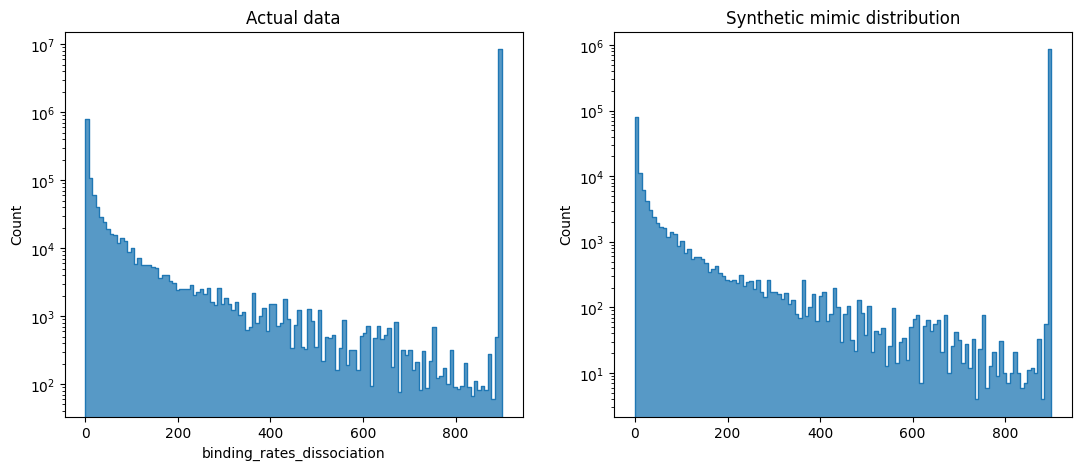

In [ ]:
plt.figure(figsize=(13, 5))
ax = plt.subplot(1,2,1)
sns.histplot(datam, x='binding_rates_dissociation', log_scale=[False, True], element='step', bins=120)
plt.title('Actual data')

ax = plt.subplot(1,2,2)
sns.histplot(sample_distribution(np.random.rand(1000000)), element='step', bins=120, log_scale=[False, True])
plt.title('Synthetic mimic distribution')

In [ ]:
# stop

There's too much of a bias towards the non-functional rate 899 at the right edge of the distribution. Let's just get rid of that last bin entirely.

In [ ]:

hist, bin_edges = hist[:-1], bin_edges[:-1]
norm_dist = np.cumsum(hist) / np.sum(hist)
norm_dist = np.concatenate([[0], norm_dist])
rate_dist = bin_edges

sample_distribution = partial(sample_distribution, norm_dist=norm_dist, rate_dist=rate_dist)


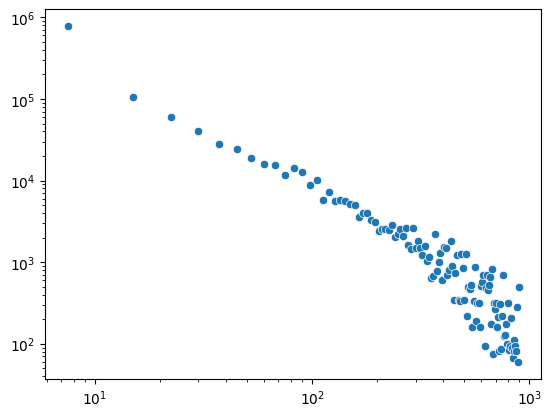

In [ ]:
sns.scatterplot(x=list(bin_edges)[1:], y=hist[:])
plt.xscale('log')
plt.yscale('log')


## Actual log likelihood

In [ ]:
ndim = 6

def loglike(B):
    
    L = - 1 / (R(*B) + 0.0001)
    
    print(L)
    
    return L


def ptform(u, distribution):
    # R_max = 1
    # R_min = 0.00001
    # x = R_max * u + R_min
    x = distribution(u)
    
    return x

# Sampling

In [ ]:

sampler = dynesty.NestedSampler(loglike, partial(ptform, distribution=sample_distribution), ndim)
sampler.run_nested(maxiter=500)
sresults = sampler.results

# fig, axes = plt.subplots(6, 13, figsize=(25, 10))
# axes = axes.reshape((6, 13))  # reshape axes

# # add white space
# [a.set_frame_on(False) for a in axes[:, 6]]
# [a.set_xticks([]) for a in axes[:, 6]]
# [a.set_yticks([]) for a in axes[:, 6]]

# # plot initial run (res1; left)
# fg, ax = dyplot.cornerpoints(sresults, cmap='plasma', truths=np.zeros(ndim),
#                              kde=False, fig=(fig, axes[:, :2]))

-0.26226250281359753
-0.2560924954324804
-0.18844381795156198
-0.1620281866996191
-0.28053041148433383
-0.27078674399648694
-0.1505462301976834
-0.2368763223040077
-0.1601577027072184
-0.2763582002369518
-0.26879138860376234
-0.32405054702774266
-0.26895740669978174
-0.3984127175566898
-0.13189492777585524
-0.30255888053668484
-0.1579204896713222
-0.3108655396571634
-0.19845853813955458
-0.19630288920680689
-0.17288472485314063
-0.30025736726362506
-0.10815409509703387
-0.1813068667816384
-0.22656789273393554
-0.22027068776641992
-0.32885023332741586
-0.21084325961239428
-0.3586743560535644
-0.17969159644760535
-0.34732524698644
-0.2953168612510968
-0.2749160060492969
-0.1578210775084954
-0.4091030265015044
-0.2637391698229964
-0.1260541110947412
-0.27413840450529775
-0.1333991505559535
-0.13877201031339878
-0.3330724050163738
-0.161215032416635
-0.2708206111604364
-0.451425282925592
-0.20097153706076662
-0.27108905032915304
-0.1768527460927537
-0.3656557035691902
-0.35485518636249425


1it [00:01,  1.85s/it, bound: 0 | nc: 1 | ncall: 501 | eff(%):  0.200 | loglstar:   -inf < -0.555 <    inf | logz: -7.465 +/-  0.117 | dlogz:    inf >  0.509]

-0.1609582967749061


2it [00:03,  1.85s/it, bound: 0 | nc: 1 | ncall: 502 | eff(%):  0.398 | loglstar:   -inf < -0.542 <    inf | logz: -6.363 +/-  0.108 | dlogz:  7.392 >  0.509]

-0.48994199842479563


3it [00:05,  1.93s/it, bound: 0 | nc: 1 | ncall: 503 | eff(%):  0.596 | loglstar:   -inf < -0.540 <    inf | logz: -5.850 +/-  0.103 | dlogz:  6.290 >  0.509]

-0.08267355096013135


4it [00:07,  1.97s/it, bound: 0 | nc: 1 | ncall: 504 | eff(%):  0.794 | loglstar:   -inf < -0.524 <    inf | logz: -5.510 +/-  0.100 | dlogz:  5.776 >  0.509]

-0.16367787303619002


5it [00:09,  1.98s/it, bound: 0 | nc: 1 | ncall: 505 | eff(%):  0.990 | loglstar:   -inf < -0.522 <    inf | logz: -5.255 +/-  0.097 | dlogz:  5.435 >  0.509]

-0.37918305953787956


6it [00:11,  2.05s/it, bound: 0 | nc: 1 | ncall: 506 | eff(%):  1.186 | loglstar:   -inf < -0.516 <    inf | logz: -5.052 +/-  0.095 | dlogz:  5.180 >  0.509]

-0.2570199312897514
-0.5394713586486471


7it [00:16,  3.00s/it, bound: 0 | nc: 2 | ncall: 508 | eff(%):  1.378 | loglstar:   -inf < -0.516 <    inf | logz: -4.883 +/-  0.093 | dlogz:  4.976 >  0.509]

-0.1262467109279745


8it [00:19,  2.83s/it, bound: 0 | nc: 1 | ncall: 509 | eff(%):  1.572 | loglstar:   -inf < -0.512 <    inf | logz: -4.739 +/-  0.092 | dlogz:  4.806 >  0.509]

-0.25168180098441334


9it [00:21,  2.72s/it, bound: 0 | nc: 1 | ncall: 510 | eff(%):  1.765 | loglstar:   -inf < -0.502 <    inf | logz: -4.612 +/-  0.090 | dlogz:  4.661 >  0.509]

-0.17451638456081076


10it [00:24,  2.64s/it, bound: 0 | nc: 1 | ncall: 511 | eff(%):  1.957 | loglstar:   -inf < -0.501 <    inf | logz: -4.499 +/-  0.089 | dlogz:  4.534 >  0.509]

-0.37386652301580287


11it [00:26,  2.58s/it, bound: 0 | nc: 1 | ncall: 512 | eff(%):  2.148 | loglstar:   -inf < -0.496 <    inf | logz: -4.397 +/-  0.088 | dlogz:  4.420 >  0.509]

-0.1880182895760884


12it [00:31,  3.14s/it, bound: 0 | nc: 1 | ncall: 513 | eff(%):  2.339 | loglstar:   -inf < -0.496 <    inf | logz: -4.305 +/-  0.087 | dlogz:  4.318 >  0.509]

-0.12194662920401314


13it [00:33,  2.75s/it, bound: 0 | nc: 1 | ncall: 514 | eff(%):  2.529 | loglstar:   -inf < -0.496 <    inf | logz: -4.221 +/-  0.086 | dlogz:  4.225 >  0.509]

-0.3847900797758975


14it [00:34,  2.48s/it, bound: 0 | nc: 1 | ncall: 515 | eff(%):  2.718 | loglstar:   -inf < -0.490 <    inf | logz: -4.143 +/-  0.085 | dlogz:  4.140 >  0.509]

-0.20950176556784977


15it [00:36,  2.30s/it, bound: 0 | nc: 1 | ncall: 516 | eff(%):  2.907 | loglstar:   -inf < -0.489 <    inf | logz: -4.071 +/-  0.084 | dlogz:  4.061 >  0.509]

-0.19422700066310697


16it [00:38,  2.16s/it, bound: 0 | nc: 1 | ncall: 517 | eff(%):  3.095 | loglstar:   -inf < -0.484 <    inf | logz: -4.003 +/-  0.084 | dlogz:  3.988 >  0.509]

-0.18927267737926426


17it [00:40,  2.05s/it, bound: 0 | nc: 1 | ncall: 518 | eff(%):  3.282 | loglstar:   -inf < -0.483 <    inf | logz: -3.940 +/-  0.083 | dlogz:  3.920 >  0.509]

-0.20619636185916482


18it [00:42,  1.98s/it, bound: 0 | nc: 1 | ncall: 519 | eff(%):  3.468 | loglstar:   -inf < -0.483 <    inf | logz: -3.881 +/-  0.082 | dlogz:  3.856 >  0.509]

-0.22139407590015006


19it [00:43,  1.92s/it, bound: 0 | nc: 1 | ncall: 520 | eff(%):  3.654 | loglstar:   -inf < -0.482 <    inf | logz: -3.825 +/-  0.081 | dlogz:  3.796 >  0.509]

-0.22056615687892403


20it [00:45,  1.92s/it, bound: 0 | nc: 1 | ncall: 521 | eff(%):  3.839 | loglstar:   -inf < -0.481 <    inf | logz: -3.772 +/-  0.081 | dlogz:  3.740 >  0.509]

-0.19453225484779083


21it [00:47,  1.89s/it, bound: 0 | nc: 1 | ncall: 522 | eff(%):  4.023 | loglstar:   -inf < -0.476 <    inf | logz: -3.721 +/-  0.080 | dlogz:  3.686 >  0.509]

-0.26733750845968446


22it [00:49,  1.86s/it, bound: 0 | nc: 1 | ncall: 523 | eff(%):  4.207 | loglstar:   -inf < -0.464 <    inf | logz: -3.673 +/-  0.080 | dlogz:  3.635 >  0.509]

-0.4366761639512331
-0.5119820674780988


23it [00:53,  2.40s/it, bound: 0 | nc: 2 | ncall: 525 | eff(%):  4.381 | loglstar:   -inf < -0.459 <    inf | logz: -3.627 +/-  0.079 | dlogz:  3.586 >  0.509]

-0.1675914332168222


24it [00:54,  2.22s/it, bound: 0 | nc: 1 | ncall: 526 | eff(%):  4.563 | loglstar:   -inf < -0.456 <    inf | logz: -3.582 +/-  0.078 | dlogz:  3.539 >  0.509]

-0.16680467002558202


25it [00:56,  2.10s/it, bound: 0 | nc: 1 | ncall: 527 | eff(%):  4.744 | loglstar:   -inf < -0.456 <    inf | logz: -3.540 +/-  0.078 | dlogz:  3.494 >  0.509]

-0.2926714743952433


26it [00:58,  2.01s/it, bound: 0 | nc: 1 | ncall: 528 | eff(%):  4.924 | loglstar:   -inf < -0.451 <    inf | logz: -3.499 +/-  0.077 | dlogz:  3.451 >  0.509]

-0.1790502377510178


27it [01:00,  1.96s/it, bound: 0 | nc: 1 | ncall: 529 | eff(%):  5.104 | loglstar:   -inf < -0.449 <    inf | logz: -3.460 +/-  0.077 | dlogz:  3.410 >  0.509]

-0.2656228722135552


28it [01:02,  1.94s/it, bound: 0 | nc: 1 | ncall: 530 | eff(%):  5.283 | loglstar:   -inf < -0.444 <    inf | logz: -3.422 +/-  0.077 | dlogz:  3.370 >  0.509]

-0.11429933225864777


29it [01:04,  1.89s/it, bound: 0 | nc: 1 | ncall: 531 | eff(%):  5.461 | loglstar:   -inf < -0.440 <    inf | logz: -3.386 +/-  0.076 | dlogz:  3.332 >  0.509]

-0.08769796788707217


30it [01:05,  1.87s/it, bound: 0 | nc: 1 | ncall: 532 | eff(%):  5.639 | loglstar:   -inf < -0.437 <    inf | logz: -3.351 +/-  0.076 | dlogz:  3.294 >  0.509]

-0.19312695219534118


31it [01:07,  1.86s/it, bound: 0 | nc: 1 | ncall: 533 | eff(%):  5.816 | loglstar:   -inf < -0.437 <    inf | logz: -3.316 +/-  0.075 | dlogz:  3.259 >  0.509]

-0.2674206876741917


32it [01:09,  1.84s/it, bound: 0 | nc: 1 | ncall: 534 | eff(%):  5.993 | loglstar:   -inf < -0.431 <    inf | logz: -3.284 +/-  0.075 | dlogz:  3.224 >  0.509]

-0.23669615399586424


33it [01:11,  1.83s/it, bound: 0 | nc: 1 | ncall: 535 | eff(%):  6.168 | loglstar:   -inf < -0.427 <    inf | logz: -3.252 +/-  0.074 | dlogz:  3.190 >  0.509]

-0.22646122113853637


34it [01:13,  1.82s/it, bound: 0 | nc: 1 | ncall: 536 | eff(%):  6.343 | loglstar:   -inf < -0.425 <    inf | logz: -3.220 +/-  0.074 | dlogz:  3.158 >  0.509]

-0.39998003371152513


35it [01:15,  1.84s/it, bound: 0 | nc: 1 | ncall: 537 | eff(%):  6.518 | loglstar:   -inf < -0.418 <    inf | logz: -3.190 +/-  0.074 | dlogz:  3.126 >  0.509]

-0.24989836429978174


36it [01:16,  1.83s/it, bound: 0 | nc: 1 | ncall: 538 | eff(%):  6.691 | loglstar:   -inf < -0.416 <    inf | logz: -3.161 +/-  0.073 | dlogz:  3.095 >  0.509]

-0.21394980766142938


37it [01:18,  1.82s/it, bound: 0 | nc: 1 | ncall: 539 | eff(%):  6.865 | loglstar:   -inf < -0.412 <    inf | logz: -3.132 +/-  0.073 | dlogz:  3.066 >  0.509]

-0.14813805254964524


38it [01:20,  1.82s/it, bound: 0 | nc: 1 | ncall: 540 | eff(%):  7.037 | loglstar:   -inf < -0.410 <    inf | logz: -3.105 +/-  0.072 | dlogz:  3.036 >  0.509]

-0.2737850059693035


39it [01:22,  1.82s/it, bound: 0 | nc: 1 | ncall: 541 | eff(%):  7.209 | loglstar:   -inf < -0.409 <    inf | logz: -3.078 +/-  0.072 | dlogz:  3.008 >  0.509]

-0.24598365154914995


40it [01:24,  1.82s/it, bound: 0 | nc: 1 | ncall: 542 | eff(%):  7.380 | loglstar:   -inf < -0.409 <    inf | logz: -3.051 +/-  0.072 | dlogz:  2.981 >  0.509]

-0.2840068003503359


41it [01:25,  1.81s/it, bound: 0 | nc: 1 | ncall: 543 | eff(%):  7.551 | loglstar:   -inf < -0.400 <    inf | logz: -3.026 +/-  0.071 | dlogz:  2.954 >  0.509]

-0.17446770407567624


42it [01:27,  1.81s/it, bound: 0 | nc: 1 | ncall: 544 | eff(%):  7.721 | loglstar:   -inf < -0.398 <    inf | logz: -3.001 +/-  0.071 | dlogz:  2.928 >  0.509]

-0.2575009294392731


43it [01:29,  1.81s/it, bound: 0 | nc: 1 | ncall: 545 | eff(%):  7.890 | loglstar:   -inf < -0.391 <    inf | logz: -2.976 +/-  0.071 | dlogz:  2.902 >  0.509]

-0.28703133085168325


44it [01:31,  1.81s/it, bound: 0 | nc: 1 | ncall: 546 | eff(%):  8.059 | loglstar:   -inf < -0.390 <    inf | logz: -2.952 +/-  0.071 | dlogz:  2.877 >  0.509]

-0.13391099071163456


45it [01:33,  1.80s/it, bound: 0 | nc: 1 | ncall: 547 | eff(%):  8.227 | loglstar:   -inf < -0.389 <    inf | logz: -2.929 +/-  0.070 | dlogz:  2.852 >  0.509]

-0.34328137607160814
-0.5276607793132202


46it [01:36,  2.37s/it, bound: 0 | nc: 2 | ncall: 549 | eff(%):  8.379 | loglstar:   -inf < -0.389 <    inf | logz: -2.906 +/-  0.070 | dlogz:  2.828 >  0.509]

-0.13763776243864323


47it [01:38,  2.28s/it, bound: 0 | nc: 1 | ncall: 550 | eff(%):  8.545 | loglstar:   -inf < -0.389 <    inf | logz: -2.883 +/-  0.070 | dlogz:  2.805 >  0.509]

-0.2869247897308048


48it [01:40,  2.20s/it, bound: 0 | nc: 1 | ncall: 551 | eff(%):  8.711 | loglstar:   -inf < -0.388 <    inf | logz: -2.862 +/-  0.069 | dlogz:  2.782 >  0.509]

-0.20679572587042144


49it [01:42,  2.13s/it, bound: 0 | nc: 1 | ncall: 552 | eff(%):  8.877 | loglstar:   -inf < -0.387 <    inf | logz: -2.840 +/-  0.069 | dlogz:  2.760 >  0.509]

-0.19078298906202212


50it [01:45,  2.19s/it, bound: 0 | nc: 1 | ncall: 553 | eff(%):  9.042 | loglstar:   -inf < -0.385 <    inf | logz: -2.819 +/-  0.069 | dlogz:  2.738 >  0.509]

-0.260681115736444
-0.4160678878499896


51it [01:50,  3.03s/it, bound: 0 | nc: 2 | ncall: 555 | eff(%):  9.189 | loglstar:   -inf < -0.383 <    inf | logz: -2.799 +/-  0.068 | dlogz:  2.717 >  0.509]

-0.1540132822134667


52it [01:52,  2.86s/it, bound: 0 | nc: 1 | ncall: 556 | eff(%):  9.353 | loglstar:   -inf < -0.382 <    inf | logz: -2.779 +/-  0.068 | dlogz:  2.696 >  0.509]

-0.30694386904584536


53it [01:55,  2.75s/it, bound: 0 | nc: 1 | ncall: 557 | eff(%):  9.515 | loglstar:   -inf < -0.382 <    inf | logz: -2.759 +/-  0.068 | dlogz:  2.675 >  0.509]

-0.2625418587156414


54it [01:57,  2.66s/it, bound: 0 | nc: 1 | ncall: 558 | eff(%):  9.677 | loglstar:   -inf < -0.381 <    inf | logz: -2.740 +/-  0.068 | dlogz:  2.655 >  0.509]

-0.30054222449527046


55it [02:00,  2.60s/it, bound: 0 | nc: 1 | ncall: 559 | eff(%):  9.839 | loglstar:   -inf < -0.379 <    inf | logz: -2.721 +/-  0.067 | dlogz:  2.636 >  0.509]

-0.21155475927891343


56it [02:02,  2.47s/it, bound: 0 | nc: 1 | ncall: 560 | eff(%): 10.000 | loglstar:   -inf < -0.377 <    inf | logz: -2.703 +/-  0.067 | dlogz:  2.616 >  0.509]

-0.23432256768688858


57it [02:03,  2.27s/it, bound: 0 | nc: 1 | ncall: 561 | eff(%): 10.160 | loglstar:   -inf < -0.374 <    inf | logz: -2.685 +/-  0.067 | dlogz:  2.597 >  0.509]

-0.19254631287574014


58it [02:05,  2.13s/it, bound: 0 | nc: 1 | ncall: 562 | eff(%): 10.320 | loglstar:   -inf < -0.370 <    inf | logz: -2.667 +/-  0.067 | dlogz:  2.579 >  0.509]

-0.20383162629527427
-0.5084366651769273


59it [02:09,  2.57s/it, bound: 0 | nc: 2 | ncall: 564 | eff(%): 10.461 | loglstar:   -inf < -0.368 <    inf | logz: -2.649 +/-  0.066 | dlogz:  2.560 >  0.509]

-0.21937971639819723


60it [02:11,  2.34s/it, bound: 0 | nc: 1 | ncall: 565 | eff(%): 10.619 | loglstar:   -inf < -0.366 <    inf | logz: -2.632 +/-  0.066 | dlogz:  2.542 >  0.509]

-0.14801250570208857


61it [02:13,  2.19s/it, bound: 0 | nc: 1 | ncall: 566 | eff(%): 10.777 | loglstar:   -inf < -0.366 <    inf | logz: -2.615 +/-  0.066 | dlogz:  2.525 >  0.509]

-0.3505248716430708


62it [02:14,  2.07s/it, bound: 0 | nc: 1 | ncall: 567 | eff(%): 10.935 | loglstar:   -inf < -0.366 <    inf | logz: -2.599 +/-  0.066 | dlogz:  2.507 >  0.509]

-0.1604128825906882


63it [02:16,  2.00s/it, bound: 0 | nc: 1 | ncall: 568 | eff(%): 11.092 | loglstar:   -inf < -0.366 <    inf | logz: -2.582 +/-  0.065 | dlogz:  2.490 >  0.509]

-0.2929762853719664
-0.43634689585144637
-0.4276537352692761


64it [02:22,  3.03s/it, bound: 0 | nc: 3 | ncall: 571 | eff(%): 11.208 | loglstar:   -inf < -0.365 <    inf | logz: -2.566 +/-  0.065 | dlogz:  2.473 >  0.509]

-0.30594501079310005


65it [02:23,  2.69s/it, bound: 0 | nc: 1 | ncall: 572 | eff(%): 11.364 | loglstar:   -inf < -0.364 <    inf | logz: -2.551 +/-  0.065 | dlogz:  2.457 >  0.509]

-0.19806268285193854


66it [02:25,  2.44s/it, bound: 0 | nc: 1 | ncall: 573 | eff(%): 11.518 | loglstar:   -inf < -0.364 <    inf | logz: -2.535 +/-  0.065 | dlogz:  2.441 >  0.509]

-0.35664162872073757


67it [02:27,  2.24s/it, bound: 0 | nc: 1 | ncall: 574 | eff(%): 11.672 | loglstar:   -inf < -0.362 <    inf | logz: -2.520 +/-  0.065 | dlogz:  2.425 >  0.509]

-0.25103638626409386


68it [02:29,  2.12s/it, bound: 0 | nc: 1 | ncall: 575 | eff(%): 11.826 | loglstar:   -inf < -0.361 <    inf | logz: -2.505 +/-  0.064 | dlogz:  2.409 >  0.509]

-0.25864756295540403


69it [02:31,  2.03s/it, bound: 0 | nc: 1 | ncall: 576 | eff(%): 11.979 | loglstar:   -inf < -0.359 <    inf | logz: -2.490 +/-  0.064 | dlogz:  2.394 >  0.509]

-0.2460127671091333


70it [02:33,  1.98s/it, bound: 0 | nc: 1 | ncall: 577 | eff(%): 12.132 | loglstar:   -inf < -0.357 <    inf | logz: -2.476 +/-  0.064 | dlogz:  2.378 >  0.509]

-0.22925276944934667


71it [02:34,  1.93s/it, bound: 0 | nc: 1 | ncall: 578 | eff(%): 12.284 | loglstar:   -inf < -0.357 <    inf | logz: -2.461 +/-  0.064 | dlogz:  2.363 >  0.509]

-0.2380288585136952


72it [02:36,  1.91s/it, bound: 0 | nc: 1 | ncall: 579 | eff(%): 12.435 | loglstar:   -inf < -0.357 <    inf | logz: -2.447 +/-  0.064 | dlogz:  2.349 >  0.509]

-0.1129479625097889


73it [02:38,  1.88s/it, bound: 0 | nc: 1 | ncall: 580 | eff(%): 12.586 | loglstar:   -inf < -0.356 <    inf | logz: -2.433 +/-  0.063 | dlogz:  2.334 >  0.509]

-0.26627346153121806


74it [02:40,  1.86s/it, bound: 0 | nc: 1 | ncall: 581 | eff(%): 12.737 | loglstar:   -inf < -0.356 <    inf | logz: -2.420 +/-  0.063 | dlogz:  2.320 >  0.509]

-0.2323893674873829


75it [02:42,  1.84s/it, bound: 0 | nc: 1 | ncall: 582 | eff(%): 12.887 | loglstar:   -inf < -0.355 <    inf | logz: -2.406 +/-  0.063 | dlogz:  2.306 >  0.509]

-0.24713468528129873


76it [02:43,  1.82s/it, bound: 0 | nc: 1 | ncall: 583 | eff(%): 13.036 | loglstar:   -inf < -0.354 <    inf | logz: -2.393 +/-  0.063 | dlogz:  2.292 >  0.509]

-0.17538317650757787
-0.3615418881008385


77it [02:47,  2.39s/it, bound: 0 | nc: 2 | ncall: 585 | eff(%): 13.162 | loglstar:   -inf < -0.352 <    inf | logz: -2.380 +/-  0.063 | dlogz:  2.278 >  0.509]

-0.22789030120557485


78it [02:49,  2.22s/it, bound: 0 | nc: 1 | ncall: 586 | eff(%): 13.311 | loglstar:   -inf < -0.352 <    inf | logz: -2.367 +/-  0.062 | dlogz:  2.264 >  0.509]

-0.17020205004125652
-0.5073332137840681


79it [02:53,  2.64s/it, bound: 0 | nc: 2 | ncall: 588 | eff(%): 13.435 | loglstar:   -inf < -0.351 <    inf | logz: -2.354 +/-  0.062 | dlogz:  2.251 >  0.509]

-0.3484004808515667


80it [02:54,  2.39s/it, bound: 0 | nc: 1 | ncall: 589 | eff(%): 13.582 | loglstar:   -inf < -0.351 <    inf | logz: -2.341 +/-  0.062 | dlogz:  2.238 >  0.509]

-0.24494071973935586


81it [02:56,  2.22s/it, bound: 0 | nc: 1 | ncall: 590 | eff(%): 13.729 | loglstar:   -inf < -0.350 <    inf | logz: -2.329 +/-  0.062 | dlogz:  2.225 >  0.509]

-0.13442201750470767


82it [02:58,  2.10s/it, bound: 0 | nc: 1 | ncall: 591 | eff(%): 13.875 | loglstar:   -inf < -0.349 <    inf | logz: -2.317 +/-  0.062 | dlogz:  2.212 >  0.509]

-0.27834238877323775


83it [03:00,  2.02s/it, bound: 0 | nc: 1 | ncall: 592 | eff(%): 14.020 | loglstar:   -inf < -0.349 <    inf | logz: -2.305 +/-  0.061 | dlogz:  2.199 >  0.509]

-0.34298373516081737


84it [03:02,  1.97s/it, bound: 0 | nc: 1 | ncall: 593 | eff(%): 14.165 | loglstar:   -inf < -0.348 <    inf | logz: -2.293 +/-  0.061 | dlogz:  2.187 >  0.509]

-0.30165212480106535


85it [03:04,  1.94s/it, bound: 0 | nc: 1 | ncall: 594 | eff(%): 14.310 | loglstar:   -inf < -0.348 <    inf | logz: -2.281 +/-  0.061 | dlogz:  2.175 >  0.509]

-0.19160252098186917


86it [03:05,  1.90s/it, bound: 0 | nc: 1 | ncall: 595 | eff(%): 14.454 | loglstar:   -inf < -0.347 <    inf | logz: -2.270 +/-  0.061 | dlogz:  2.162 >  0.509]

-0.2290072589296
-0.4675092666113452


87it [03:12,  3.26s/it, bound: 0 | nc: 2 | ncall: 597 | eff(%): 14.573 | loglstar:   -inf < -0.347 <    inf | logz: -2.258 +/-  0.061 | dlogz:  2.150 >  0.509]

-0.3138631218103511


88it [03:14,  2.87s/it, bound: 0 | nc: 1 | ncall: 598 | eff(%): 14.716 | loglstar:   -inf < -0.345 <    inf | logz: -2.247 +/-  0.061 | dlogz:  2.139 >  0.509]

-0.23795977032827814


89it [03:16,  2.59s/it, bound: 0 | nc: 1 | ncall: 599 | eff(%): 14.858 | loglstar:   -inf < -0.345 <    inf | logz: -2.236 +/-  0.060 | dlogz:  2.127 >  0.509]

-0.2868020102147464


90it [03:17,  2.31s/it, bound: 0 | nc: 1 | ncall: 600 | eff(%): 15.000 | loglstar:   -inf < -0.345 <    inf | logz: -2.225 +/-  0.060 | dlogz:  2.115 >  0.509]

-0.12797713131148725


91it [03:19,  2.12s/it, bound: 0 | nc: 1 | ncall: 601 | eff(%): 15.141 | loglstar:   -inf < -0.345 <    inf | logz: -2.214 +/-  0.060 | dlogz:  2.104 >  0.509]

-0.2714282819023885


92it [03:21,  1.99s/it, bound: 0 | nc: 1 | ncall: 602 | eff(%): 15.282 | loglstar:   -inf < -0.344 <    inf | logz: -2.203 +/-  0.060 | dlogz:  2.093 >  0.509]

-0.1885178103324606
-0.3762241615175608


93it [03:24,  2.41s/it, bound: 0 | nc: 2 | ncall: 604 | eff(%): 15.397 | loglstar:   -inf < -0.343 <    inf | logz: -2.193 +/-  0.060 | dlogz:  2.081 >  0.509]

-0.2783364411234657


94it [03:26,  2.20s/it, bound: 0 | nc: 1 | ncall: 605 | eff(%): 15.537 | loglstar:   -inf < -0.343 <    inf | logz: -2.182 +/-  0.060 | dlogz:  2.070 >  0.509]

-0.21328085676573402
-0.3526170374860602


95it [03:29,  2.56s/it, bound: 0 | nc: 2 | ncall: 607 | eff(%): 15.651 | loglstar:   -inf < -0.341 <    inf | logz: -2.172 +/-  0.059 | dlogz:  2.059 >  0.509]

-0.1495814016252466


96it [03:31,  2.31s/it, bound: 0 | nc: 1 | ncall: 608 | eff(%): 15.789 | loglstar:   -inf < -0.340 <    inf | logz: -2.161 +/-  0.059 | dlogz:  2.049 >  0.509]

-0.30904999704050296


97it [03:33,  2.12s/it, bound: 0 | nc: 1 | ncall: 609 | eff(%): 15.928 | loglstar:   -inf < -0.340 <    inf | logz: -2.151 +/-  0.059 | dlogz:  2.038 >  0.509]

-0.20573130149823476


98it [03:34,  2.00s/it, bound: 0 | nc: 1 | ncall: 610 | eff(%): 16.066 | loglstar:   -inf < -0.340 <    inf | logz: -2.141 +/-  0.059 | dlogz:  2.028 >  0.509]

-0.25240417363241746


99it [03:36,  1.93s/it, bound: 0 | nc: 1 | ncall: 611 | eff(%): 16.203 | loglstar:   -inf < -0.338 <    inf | logz: -2.131 +/-  0.059 | dlogz:  2.017 >  0.509]

-0.1413103812304093


100it [03:38,  1.86s/it, bound: 0 | nc: 1 | ncall: 612 | eff(%): 16.340 | loglstar:   -inf < -0.336 <    inf | logz: -2.122 +/-  0.059 | dlogz:  2.007 >  0.509]

-0.2202734640909266
-0.33843852632367627
-0.3773891223145901


101it [03:43,  2.81s/it, bound: 0 | nc: 3 | ncall: 615 | eff(%): 16.423 | loglstar:   -inf < -0.336 <    inf | logz: -2.112 +/-  0.058 | dlogz:  1.997 >  0.509]

-0.2349261673882689


102it [03:45,  2.47s/it, bound: 0 | nc: 1 | ncall: 616 | eff(%): 16.558 | loglstar:   -inf < -0.335 <    inf | logz: -2.102 +/-  0.058 | dlogz:  1.986 >  0.509]

-0.2594017437011652


103it [03:46,  2.26s/it, bound: 0 | nc: 1 | ncall: 617 | eff(%): 16.694 | loglstar:   -inf < -0.334 <    inf | logz: -2.093 +/-  0.058 | dlogz:  1.976 >  0.509]

-0.12221085939332173


104it [03:48,  2.10s/it, bound: 0 | nc: 1 | ncall: 618 | eff(%): 16.828 | loglstar:   -inf < -0.333 <    inf | logz: -2.083 +/-  0.058 | dlogz:  1.967 >  0.509]

-0.1645535489881162


105it [03:50,  1.98s/it, bound: 0 | nc: 1 | ncall: 619 | eff(%): 16.963 | loglstar:   -inf < -0.332 <    inf | logz: -2.074 +/-  0.058 | dlogz:  1.957 >  0.509]

-0.15453115529789177


106it [03:52,  1.90s/it, bound: 0 | nc: 1 | ncall: 620 | eff(%): 17.097 | loglstar:   -inf < -0.331 <    inf | logz: -2.065 +/-  0.058 | dlogz:  1.947 >  0.509]

-0.20230298618997725


107it [03:53,  1.84s/it, bound: 0 | nc: 1 | ncall: 621 | eff(%): 17.230 | loglstar:   -inf < -0.330 <    inf | logz: -2.056 +/-  0.058 | dlogz:  1.938 >  0.509]

-0.1960688343221053


108it [03:55,  1.79s/it, bound: 0 | nc: 1 | ncall: 622 | eff(%): 17.363 | loglstar:   -inf < -0.330 <    inf | logz: -2.047 +/-  0.057 | dlogz:  1.928 >  0.509]

-0.2853253968549235


109it [03:57,  1.76s/it, bound: 0 | nc: 1 | ncall: 623 | eff(%): 17.496 | loglstar:   -inf < -0.329 <    inf | logz: -2.038 +/-  0.057 | dlogz:  1.919 >  0.509]

-0.22540906459188942


110it [03:58,  1.73s/it, bound: 0 | nc: 1 | ncall: 624 | eff(%): 17.628 | loglstar:   -inf < -0.328 <    inf | logz: -2.029 +/-  0.057 | dlogz:  1.909 >  0.509]

-0.2839852634766257


111it [04:00,  1.72s/it, bound: 0 | nc: 1 | ncall: 625 | eff(%): 17.760 | loglstar:   -inf < -0.328 <    inf | logz: -2.020 +/-  0.057 | dlogz:  1.900 >  0.509]

-0.30561931325024944
-0.3348470764939866


112it [04:03,  2.24s/it, bound: 0 | nc: 2 | ncall: 627 | eff(%): 17.863 | loglstar:   -inf < -0.327 <    inf | logz: -2.012 +/-  0.057 | dlogz:  1.891 >  0.509]

-0.2613258796383909


113it [04:05,  2.07s/it, bound: 0 | nc: 1 | ncall: 628 | eff(%): 17.994 | loglstar:   -inf < -0.327 <    inf | logz: -2.003 +/-  0.057 | dlogz:  1.882 >  0.509]

-0.25307743095876173


114it [04:07,  1.96s/it, bound: 0 | nc: 1 | ncall: 629 | eff(%): 18.124 | loglstar:   -inf < -0.326 <    inf | logz: -1.995 +/-  0.057 | dlogz:  1.873 >  0.509]

-0.17351531258144356
-0.32754850896750365


115it [04:10,  2.41s/it, bound: 0 | nc: 2 | ncall: 631 | eff(%): 18.225 | loglstar:   -inf < -0.326 <    inf | logz: -1.986 +/-  0.056 | dlogz:  1.864 >  0.509]

-0.1881376933121868


116it [04:12,  2.20s/it, bound: 0 | nc: 1 | ncall: 632 | eff(%): 18.354 | loglstar:   -inf < -0.324 <    inf | logz: -1.978 +/-  0.056 | dlogz:  1.855 >  0.509]

-0.2462520409587823


117it [04:14,  2.04s/it, bound: 0 | nc: 1 | ncall: 633 | eff(%): 18.483 | loglstar:   -inf < -0.324 <    inf | logz: -1.970 +/-  0.056 | dlogz:  1.847 >  0.509]

-0.24441377517416782


118it [04:15,  1.93s/it, bound: 0 | nc: 1 | ncall: 634 | eff(%): 18.612 | loglstar:   -inf < -0.323 <    inf | logz: -1.962 +/-  0.056 | dlogz:  1.838 >  0.509]

-0.28904023374570265


119it [04:17,  1.85s/it, bound: 0 | nc: 1 | ncall: 635 | eff(%): 18.740 | loglstar:   -inf < -0.323 <    inf | logz: -1.953 +/-  0.056 | dlogz:  1.829 >  0.509]

-0.2465305510212938


120it [04:19,  1.80s/it, bound: 0 | nc: 1 | ncall: 636 | eff(%): 18.868 | loglstar:   -inf < -0.323 <    inf | logz: -1.945 +/-  0.056 | dlogz:  1.821 >  0.509]

-0.18896057000647937
-0.425883842117957


121it [04:22,  2.28s/it, bound: 0 | nc: 2 | ncall: 638 | eff(%): 18.966 | loglstar:   -inf < -0.322 <    inf | logz: -1.937 +/-  0.056 | dlogz:  1.813 >  0.509]

-0.28086911504071255
-0.5004909126834544


122it [04:25,  2.61s/it, bound: 0 | nc: 2 | ncall: 640 | eff(%): 19.062 | loglstar:   -inf < -0.321 <    inf | logz: -1.930 +/-  0.055 | dlogz:  1.804 >  0.509]

-0.1779799552144848


123it [04:27,  2.34s/it, bound: 0 | nc: 1 | ncall: 641 | eff(%): 19.189 | loglstar:   -inf < -0.320 <    inf | logz: -1.922 +/-  0.055 | dlogz:  1.796 >  0.509]

-0.2994723393433452


124it [04:29,  2.14s/it, bound: 0 | nc: 1 | ncall: 642 | eff(%): 19.315 | loglstar:   -inf < -0.318 <    inf | logz: -1.914 +/-  0.055 | dlogz:  1.788 >  0.509]

-0.12995950830980102


125it [04:30,  2.01s/it, bound: 0 | nc: 1 | ncall: 643 | eff(%): 19.440 | loglstar:   -inf < -0.318 <    inf | logz: -1.906 +/-  0.055 | dlogz:  1.780 >  0.509]

-0.18556355226668422


126it [04:32,  1.92s/it, bound: 0 | nc: 1 | ncall: 644 | eff(%): 19.565 | loglstar:   -inf < -0.317 <    inf | logz: -1.899 +/-  0.055 | dlogz:  1.772 >  0.509]

-0.22260326773159736


127it [04:34,  1.85s/it, bound: 0 | nc: 1 | ncall: 645 | eff(%): 19.690 | loglstar:   -inf < -0.316 <    inf | logz: -1.891 +/-  0.055 | dlogz:  1.764 >  0.509]

-0.10201541128804988


128it [04:36,  1.80s/it, bound: 0 | nc: 1 | ncall: 646 | eff(%): 19.814 | loglstar:   -inf < -0.315 <    inf | logz: -1.884 +/-  0.055 | dlogz:  1.756 >  0.509]

-0.25034691140615767


129it [04:37,  1.76s/it, bound: 0 | nc: 1 | ncall: 647 | eff(%): 19.938 | loglstar:   -inf < -0.315 <    inf | logz: -1.877 +/-  0.055 | dlogz:  1.748 >  0.509]

-0.295984804152078


130it [04:39,  1.75s/it, bound: 0 | nc: 1 | ncall: 648 | eff(%): 20.062 | loglstar:   -inf < -0.315 <    inf | logz: -1.869 +/-  0.054 | dlogz:  1.740 >  0.509]

-0.11766489612693211


131it [04:41,  1.73s/it, bound: 0 | nc: 1 | ncall: 649 | eff(%): 20.185 | loglstar:   -inf < -0.314 <    inf | logz: -1.862 +/-  0.054 | dlogz:  1.733 >  0.509]

-0.23282752986562935


132it [04:42,  1.71s/it, bound: 0 | nc: 1 | ncall: 650 | eff(%): 20.308 | loglstar:   -inf < -0.314 <    inf | logz: -1.855 +/-  0.054 | dlogz:  1.725 >  0.509]

-0.15540712709439455


133it [04:44,  1.71s/it, bound: 0 | nc: 1 | ncall: 651 | eff(%): 20.430 | loglstar:   -inf < -0.314 <    inf | logz: -1.848 +/-  0.054 | dlogz:  1.718 >  0.509]

-0.20533879948083406


134it [04:46,  1.70s/it, bound: 0 | nc: 1 | ncall: 652 | eff(%): 20.552 | loglstar:   -inf < -0.312 <    inf | logz: -1.841 +/-  0.054 | dlogz:  1.710 >  0.509]

-0.15266596404254817
-0.4785630131388184


135it [04:49,  2.21s/it, bound: 0 | nc: 2 | ncall: 654 | eff(%): 20.642 | loglstar:   -inf < -0.311 <    inf | logz: -1.833 +/-  0.054 | dlogz:  1.703 >  0.509]

-0.23490324770240456
-0.3652135236600642


136it [04:52,  2.57s/it, bound: 0 | nc: 2 | ncall: 656 | eff(%): 20.732 | loglstar:   -inf < -0.311 <    inf | logz: -1.827 +/-  0.054 | dlogz:  1.695 >  0.509]

-0.24697304141885348


137it [04:54,  2.30s/it, bound: 0 | nc: 1 | ncall: 657 | eff(%): 20.852 | loglstar:   -inf < -0.310 <    inf | logz: -1.820 +/-  0.054 | dlogz:  1.688 >  0.509]

-0.23273954829208787
-0.4274215837602314
-0.3547760955163634


138it [04:59,  3.13s/it, bound: 0 | nc: 3 | ncall: 660 | eff(%): 20.909 | loglstar:   -inf < -0.310 <    inf | logz: -1.813 +/-  0.053 | dlogz:  1.681 >  0.509]

-0.22817430218858903


139it [05:01,  2.69s/it, bound: 0 | nc: 1 | ncall: 661 | eff(%): 21.029 | loglstar:   -inf < -0.310 <    inf | logz: -1.806 +/-  0.053 | dlogz:  1.674 >  0.509]

-0.09611811025302108


140it [05:03,  2.40s/it, bound: 0 | nc: 1 | ncall: 662 | eff(%): 21.148 | loglstar:   -inf < -0.310 <    inf | logz: -1.799 +/-  0.053 | dlogz:  1.666 >  0.509]

-0.17644246190573096


141it [05:04,  2.19s/it, bound: 0 | nc: 1 | ncall: 663 | eff(%): 21.267 | loglstar:   -inf < -0.309 <    inf | logz: -1.793 +/-  0.053 | dlogz:  1.659 >  0.509]

-0.3085422923681331


142it [05:06,  2.04s/it, bound: 0 | nc: 1 | ncall: 664 | eff(%): 21.386 | loglstar:   -inf < -0.309 <    inf | logz: -1.786 +/-  0.053 | dlogz:  1.652 >  0.509]

-0.16524494720123256


143it [05:08,  1.93s/it, bound: 0 | nc: 1 | ncall: 665 | eff(%): 21.504 | loglstar:   -inf < -0.309 <    inf | logz: -1.779 +/-  0.053 | dlogz:  1.645 >  0.509]

-0.22805549806614978


144it [05:09,  1.85s/it, bound: 0 | nc: 1 | ncall: 666 | eff(%): 21.622 | loglstar:   -inf < -0.308 <    inf | logz: -1.773 +/-  0.053 | dlogz:  1.639 >  0.509]

-0.13071803422984088


145it [05:11,  1.81s/it, bound: 0 | nc: 1 | ncall: 667 | eff(%): 21.739 | loglstar:   -inf < -0.307 <    inf | logz: -1.766 +/-  0.053 | dlogz:  1.632 >  0.509]

-0.19899523296969054


146it [05:13,  1.77s/it, bound: 0 | nc: 1 | ncall: 668 | eff(%): 21.856 | loglstar:   -inf < -0.307 <    inf | logz: -1.760 +/-  0.053 | dlogz:  1.625 >  0.509]

-0.30041575779943264


147it [05:15,  1.77s/it, bound: 0 | nc: 1 | ncall: 669 | eff(%): 21.973 | loglstar:   -inf < -0.306 <    inf | logz: -1.754 +/-  0.052 | dlogz:  1.618 >  0.509]

-0.2524865408256201
-0.3936333092309262


148it [05:18,  2.26s/it, bound: 0 | nc: 2 | ncall: 671 | eff(%): 22.057 | loglstar:   -inf < -0.306 <    inf | logz: -1.747 +/-  0.052 | dlogz:  1.611 >  0.509]

-0.18482854122502812


149it [05:20,  2.09s/it, bound: 0 | nc: 1 | ncall: 672 | eff(%): 22.173 | loglstar:   -inf < -0.306 <    inf | logz: -1.741 +/-  0.052 | dlogz:  1.605 >  0.509]

-0.23580179414009828
-0.3754124147627619


150it [05:23,  2.47s/it, bound: 0 | nc: 2 | ncall: 674 | eff(%): 22.255 | loglstar:   -inf < -0.305 <    inf | logz: -1.735 +/-  0.052 | dlogz:  1.598 >  0.509]

-0.07481491593929109


151it [05:25,  2.23s/it, bound: 0 | nc: 1 | ncall: 675 | eff(%): 22.370 | loglstar:   -inf < -0.304 <    inf | logz: -1.729 +/-  0.052 | dlogz:  1.592 >  0.509]

-0.19660716966894035


152it [05:26,  2.10s/it, bound: 0 | nc: 1 | ncall: 676 | eff(%): 22.485 | loglstar:   -inf < -0.303 <    inf | logz: -1.723 +/-  0.052 | dlogz:  1.585 >  0.509]

-0.25321169735278837


153it [05:28,  1.97s/it, bound: 0 | nc: 1 | ncall: 677 | eff(%): 22.600 | loglstar:   -inf < -0.303 <    inf | logz: -1.717 +/-  0.052 | dlogz:  1.579 >  0.509]

-0.1950730062027967


154it [05:30,  1.89s/it, bound: 0 | nc: 1 | ncall: 678 | eff(%): 22.714 | loglstar:   -inf < -0.302 <    inf | logz: -1.711 +/-  0.052 | dlogz:  1.572 >  0.509]

-0.17268701600448527


155it [05:31,  1.83s/it, bound: 0 | nc: 1 | ncall: 679 | eff(%): 22.828 | loglstar:   -inf < -0.301 <    inf | logz: -1.705 +/-  0.052 | dlogz:  1.566 >  0.509]

-0.2092082942612572


156it [05:33,  1.79s/it, bound: 0 | nc: 1 | ncall: 680 | eff(%): 22.941 | loglstar:   -inf < -0.301 <    inf | logz: -1.699 +/-  0.051 | dlogz:  1.560 >  0.509]

-0.17131784015573198


157it [05:35,  1.76s/it, bound: 0 | nc: 1 | ncall: 681 | eff(%): 23.054 | loglstar:   -inf < -0.301 <    inf | logz: -1.693 +/-  0.051 | dlogz:  1.553 >  0.509]

-0.2713918216812482


158it [05:37,  1.73s/it, bound: 0 | nc: 1 | ncall: 682 | eff(%): 23.167 | loglstar:   -inf < -0.301 <    inf | logz: -1.687 +/-  0.051 | dlogz:  1.547 >  0.509]

-0.1936238263520616


159it [05:38,  1.71s/it, bound: 0 | nc: 1 | ncall: 683 | eff(%): 23.280 | loglstar:   -inf < -0.300 <    inf | logz: -1.681 +/-  0.051 | dlogz:  1.541 >  0.509]

-0.15754809863446417
-0.3136792588217169


160it [05:42,  2.22s/it, bound: 0 | nc: 2 | ncall: 685 | eff(%): 23.358 | loglstar:   -inf < -0.300 <    inf | logz: -1.675 +/-  0.051 | dlogz:  1.535 >  0.509]

-0.22268755828760448


161it [05:43,  2.05s/it, bound: 0 | nc: 1 | ncall: 686 | eff(%): 23.469 | loglstar:   -inf < -0.300 <    inf | logz: -1.670 +/-  0.051 | dlogz:  1.529 >  0.509]

-0.27040489610265644


162it [05:45,  1.94s/it, bound: 0 | nc: 1 | ncall: 687 | eff(%): 23.581 | loglstar:   -inf < -0.300 <    inf | logz: -1.664 +/-  0.051 | dlogz:  1.523 >  0.509]

-0.24914934451359744
-0.30696231186351347
-0.3364438246250838


163it [05:50,  2.89s/it, bound: 0 | nc: 3 | ncall: 690 | eff(%): 23.623 | loglstar:   -inf < -0.299 <    inf | logz: -1.658 +/-  0.051 | dlogz:  1.517 >  0.509]

-0.25369687046446066


164it [05:52,  2.52s/it, bound: 0 | nc: 1 | ncall: 691 | eff(%): 23.734 | loglstar:   -inf < -0.299 <    inf | logz: -1.653 +/-  0.051 | dlogz:  1.511 >  0.509]

-0.1699571603185043


165it [05:53,  2.27s/it, bound: 0 | nc: 1 | ncall: 692 | eff(%): 23.844 | loglstar:   -inf < -0.299 <    inf | logz: -1.647 +/-  0.050 | dlogz:  1.505 >  0.509]

-0.29782467207159125


166it [05:58,  2.92s/it, bound: 0 | nc: 1 | ncall: 693 | eff(%): 23.954 | loglstar:   -inf < -0.298 <    inf | logz: -1.642 +/-  0.050 | dlogz:  1.499 >  0.509]

-0.1231707813265159


167it [05:59,  2.55s/it, bound: 0 | nc: 1 | ncall: 694 | eff(%): 24.063 | loglstar:   -inf < -0.298 <    inf | logz: -1.636 +/-  0.050 | dlogz:  1.493 >  0.509]

-0.1991317324422574


168it [06:01,  2.29s/it, bound: 0 | nc: 1 | ncall: 695 | eff(%): 24.173 | loglstar:   -inf < -0.298 <    inf | logz: -1.631 +/-  0.050 | dlogz:  1.487 >  0.509]

-0.1639811683746998


169it [06:03,  2.11s/it, bound: 0 | nc: 1 | ncall: 696 | eff(%): 24.282 | loglstar:   -inf < -0.297 <    inf | logz: -1.625 +/-  0.050 | dlogz:  1.482 >  0.509]

-0.22159734456563981


170it [06:05,  1.98s/it, bound: 0 | nc: 1 | ncall: 697 | eff(%): 24.390 | loglstar:   -inf < -0.297 <    inf | logz: -1.620 +/-  0.050 | dlogz:  1.476 >  0.509]

-0.13517065546934512


171it [06:06,  1.89s/it, bound: 0 | nc: 1 | ncall: 698 | eff(%): 24.499 | loglstar:   -inf < -0.296 <    inf | logz: -1.615 +/-  0.050 | dlogz:  1.470 >  0.509]

-0.18158540984462063


172it [06:08,  1.83s/it, bound: 0 | nc: 1 | ncall: 699 | eff(%): 24.607 | loglstar:   -inf < -0.296 <    inf | logz: -1.609 +/-  0.050 | dlogz:  1.465 >  0.509]

-0.24996985217344933


173it [06:10,  1.81s/it, bound: 0 | nc: 1 | ncall: 700 | eff(%): 24.714 | loglstar:   -inf < -0.296 <    inf | logz: -1.604 +/-  0.050 | dlogz:  1.459 >  0.509]

-0.10460627445458875


174it [06:11,  1.77s/it, bound: 0 | nc: 1 | ncall: 701 | eff(%): 24.822 | loglstar:   -inf < -0.295 <    inf | logz: -1.599 +/-  0.050 | dlogz:  1.453 >  0.509]

-0.24801444016243032
-0.38238092239964033


175it [06:15,  2.27s/it, bound: 0 | nc: 2 | ncall: 703 | eff(%): 24.893 | loglstar:   -inf < -0.294 <    inf | logz: -1.594 +/-  0.049 | dlogz:  1.448 >  0.509]

-0.15845203997138105


176it [06:16,  2.09s/it, bound: 0 | nc: 1 | ncall: 704 | eff(%): 25.000 | loglstar:   -inf < -0.294 <    inf | logz: -1.589 +/-  0.049 | dlogz:  1.442 >  0.509]

-0.1525507031332996


177it [06:18,  1.96s/it, bound: 0 | nc: 1 | ncall: 705 | eff(%): 25.106 | loglstar:   -inf < -0.294 <    inf | logz: -1.583 +/-  0.049 | dlogz:  1.437 >  0.509]

-0.07933554629269068


178it [06:20,  1.88s/it, bound: 0 | nc: 1 | ncall: 706 | eff(%): 25.212 | loglstar:   -inf < -0.293 <    inf | logz: -1.578 +/-  0.049 | dlogz:  1.432 >  0.509]

-0.19389566536584643


179it [06:21,  1.82s/it, bound: 0 | nc: 1 | ncall: 707 | eff(%): 25.318 | loglstar:   -inf < -0.293 <    inf | logz: -1.573 +/-  0.049 | dlogz:  1.426 >  0.509]

-0.12314924189566463


180it [06:23,  1.78s/it, bound: 0 | nc: 1 | ncall: 708 | eff(%): 25.424 | loglstar:   -inf < -0.293 <    inf | logz: -1.568 +/-  0.049 | dlogz:  1.421 >  0.509]

-0.2445076989431659
-0.3761031167153546


181it [06:27,  2.25s/it, bound: 0 | nc: 2 | ncall: 710 | eff(%): 25.493 | loglstar:   -inf < -0.293 <    inf | logz: -1.563 +/-  0.049 | dlogz:  1.416 >  0.509]

-0.26143824043725095
-0.4803403725771284


182it [06:30,  2.59s/it, bound: 0 | nc: 2 | ncall: 712 | eff(%): 25.562 | loglstar:   -inf < -0.293 <    inf | logz: -1.558 +/-  0.049 | dlogz:  1.410 >  0.509]

-0.08162410078894246


183it [06:32,  2.32s/it, bound: 0 | nc: 1 | ncall: 713 | eff(%): 25.666 | loglstar:   -inf < -0.292 <    inf | logz: -1.553 +/-  0.049 | dlogz:  1.405 >  0.509]

-0.12663457632123984


184it [06:33,  2.15s/it, bound: 0 | nc: 1 | ncall: 714 | eff(%): 25.770 | loglstar:   -inf < -0.292 <    inf | logz: -1.549 +/-  0.049 | dlogz:  1.400 >  0.509]

-0.24345141352766894
-0.31890402457859535
-0.36299689118940703


185it [06:38,  3.03s/it, bound: 0 | nc: 3 | ncall: 717 | eff(%): 25.802 | loglstar:   -inf < -0.292 <    inf | logz: -1.544 +/-  0.049 | dlogz:  1.395 >  0.509]

-0.2507946272404695
-0.34701535879687134


186it [06:42,  3.12s/it, bound: 0 | nc: 2 | ncall: 719 | eff(%): 25.869 | loglstar:   -inf < -0.291 <    inf | logz: -1.539 +/-  0.048 | dlogz:  1.390 >  0.509]

-0.2795515448756706


187it [06:43,  2.69s/it, bound: 0 | nc: 1 | ncall: 720 | eff(%): 25.972 | loglstar:   -inf < -0.291 <    inf | logz: -1.534 +/-  0.048 | dlogz:  1.384 >  0.509]

-0.20694555012372837


188it [06:45,  2.41s/it, bound: 0 | nc: 1 | ncall: 721 | eff(%): 26.075 | loglstar:   -inf < -0.291 <    inf | logz: -1.529 +/-  0.048 | dlogz:  1.379 >  0.509]

-0.26068958947467147


189it [06:47,  2.18s/it, bound: 0 | nc: 1 | ncall: 722 | eff(%): 26.177 | loglstar:   -inf < -0.291 <    inf | logz: -1.525 +/-  0.048 | dlogz:  1.374 >  0.509]

-0.19886286158139446


190it [06:49,  2.04s/it, bound: 0 | nc: 1 | ncall: 723 | eff(%): 26.279 | loglstar:   -inf < -0.291 <    inf | logz: -1.520 +/-  0.048 | dlogz:  1.369 >  0.509]

-0.17647310703269162


191it [06:50,  1.94s/it, bound: 0 | nc: 1 | ncall: 724 | eff(%): 26.381 | loglstar:   -inf < -0.291 <    inf | logz: -1.515 +/-  0.048 | dlogz:  1.364 >  0.509]

-0.2850129505238297


192it [06:52,  1.86s/it, bound: 0 | nc: 1 | ncall: 725 | eff(%): 26.483 | loglstar:   -inf < -0.290 <    inf | logz: -1.511 +/-  0.048 | dlogz:  1.359 >  0.509]

-0.2144383172641038


193it [06:54,  1.81s/it, bound: 0 | nc: 1 | ncall: 726 | eff(%): 26.584 | loglstar:   -inf < -0.290 <    inf | logz: -1.506 +/-  0.048 | dlogz:  1.354 >  0.509]

-0.2750935576038039


194it [06:55,  1.77s/it, bound: 0 | nc: 1 | ncall: 727 | eff(%): 26.685 | loglstar:   -inf < -0.289 <    inf | logz: -1.502 +/-  0.048 | dlogz:  1.350 >  0.509]

-0.16065288873123088
-0.3718781732319275
-0.3182445360618803


195it [07:00,  2.77s/it, bound: 0 | nc: 3 | ncall: 730 | eff(%): 26.712 | loglstar:   -inf < -0.287 <    inf | logz: -1.497 +/-  0.048 | dlogz:  1.345 >  0.509]

-0.1943151111658454


196it [07:02,  2.44s/it, bound: 0 | nc: 1 | ncall: 731 | eff(%): 26.813 | loglstar:   -inf < -0.287 <    inf | logz: -1.492 +/-  0.048 | dlogz:  1.340 >  0.509]

-0.25823254469898893


197it [07:04,  2.23s/it, bound: 0 | nc: 1 | ncall: 732 | eff(%): 26.913 | loglstar:   -inf < -0.287 <    inf | logz: -1.488 +/-  0.047 | dlogz:  1.335 >  0.509]

-0.2433149306795434
-0.4028459404172262


198it [07:07,  2.57s/it, bound: 0 | nc: 2 | ncall: 734 | eff(%): 26.975 | loglstar:   -inf < -0.287 <    inf | logz: -1.483 +/-  0.047 | dlogz:  1.330 >  0.509]

-0.2500527399196551


199it [07:09,  2.30s/it, bound: 0 | nc: 1 | ncall: 735 | eff(%): 27.075 | loglstar:   -inf < -0.287 <    inf | logz: -1.479 +/-  0.047 | dlogz:  1.325 >  0.509]

-0.24564792173858424
-0.37424454644785626
-0.40446887661136677
-0.4219719187046869


200it [07:16,  3.64s/it, bound: 0 | nc: 4 | ncall: 739 | eff(%): 27.064 | loglstar:   -inf < -0.286 <    inf | logz: -1.475 +/-  0.047 | dlogz:  1.321 >  0.509]

-0.2838337324360462
-0.34551956861525457
-0.32353065788227614


201it [07:21,  4.05s/it, bound: 0 | nc: 3 | ncall: 742 | eff(%): 27.089 | loglstar:   -inf < -0.285 <    inf | logz: -1.470 +/-  0.047 | dlogz:  1.316 >  0.509]

-0.2487312094752779


202it [07:22,  3.33s/it, bound: 0 | nc: 1 | ncall: 743 | eff(%): 27.187 | loglstar:   -inf < -0.285 <    inf | logz: -1.466 +/-  0.047 | dlogz:  1.311 >  0.509]

-0.28135279157050286


203it [07:24,  2.84s/it, bound: 0 | nc: 1 | ncall: 744 | eff(%): 27.285 | loglstar:   -inf < -0.285 <    inf | logz: -1.462 +/-  0.047 | dlogz:  1.307 >  0.509]

-0.24626447522475114


204it [07:26,  2.50s/it, bound: 0 | nc: 1 | ncall: 745 | eff(%): 27.383 | loglstar:   -inf < -0.285 <    inf | logz: -1.457 +/-  0.047 | dlogz:  1.302 >  0.509]

-0.16720512441527452


205it [07:27,  2.26s/it, bound: 0 | nc: 1 | ncall: 746 | eff(%): 27.480 | loglstar:   -inf < -0.284 <    inf | logz: -1.453 +/-  0.047 | dlogz:  1.298 >  0.509]

-0.23775425562436373
-0.4446224675644149


206it [07:31,  2.59s/it, bound: 0 | nc: 2 | ncall: 748 | eff(%): 27.540 | loglstar:   -inf < -0.284 <    inf | logz: -1.449 +/-  0.047 | dlogz:  1.293 >  0.509]

-0.2765191699795348


207it [07:32,  2.32s/it, bound: 0 | nc: 1 | ncall: 749 | eff(%): 27.637 | loglstar:   -inf < -0.284 <    inf | logz: -1.444 +/-  0.047 | dlogz:  1.288 >  0.509]

-0.10779634550621027


208it [07:34,  2.13s/it, bound: 0 | nc: 1 | ncall: 750 | eff(%): 27.733 | loglstar:   -inf < -0.282 <    inf | logz: -1.440 +/-  0.047 | dlogz:  1.284 >  0.509]

-0.11711175400437474


209it [07:36,  2.00s/it, bound: 0 | nc: 1 | ncall: 751 | eff(%): 27.830 | loglstar:   -inf < -0.282 <    inf | logz: -1.436 +/-  0.046 | dlogz:  1.279 >  0.509]

-0.10269222297937192


210it [07:38,  1.91s/it, bound: 0 | nc: 1 | ncall: 752 | eff(%): 27.926 | loglstar:   -inf < -0.281 <    inf | logz: -1.432 +/-  0.046 | dlogz:  1.275 >  0.509]

-0.2008496614920088


211it [07:39,  1.84s/it, bound: 0 | nc: 1 | ncall: 753 | eff(%): 28.021 | loglstar:   -inf < -0.281 <    inf | logz: -1.428 +/-  0.046 | dlogz:  1.271 >  0.509]

-0.18251582141486467


212it [07:41,  1.79s/it, bound: 0 | nc: 1 | ncall: 754 | eff(%): 28.117 | loglstar:   -inf < -0.281 <    inf | logz: -1.424 +/-  0.046 | dlogz:  1.266 >  0.509]

-0.23819436862088378


213it [07:43,  1.76s/it, bound: 0 | nc: 1 | ncall: 755 | eff(%): 28.212 | loglstar:   -inf < -0.281 <    inf | logz: -1.420 +/-  0.046 | dlogz:  1.262 >  0.509]

-0.21819414334697534


214it [07:44,  1.73s/it, bound: 0 | nc: 1 | ncall: 756 | eff(%): 28.307 | loglstar:   -inf < -0.281 <    inf | logz: -1.416 +/-  0.046 | dlogz:  1.257 >  0.509]

-0.23575863833616836
-0.4472316412672459


215it [07:48,  2.23s/it, bound: 0 | nc: 2 | ncall: 758 | eff(%): 28.364 | loglstar:   -inf < -0.280 <    inf | logz: -1.411 +/-  0.046 | dlogz:  1.253 >  0.509]

-0.149857491547415
-0.31101608773508416


216it [07:51,  2.57s/it, bound: 0 | nc: 2 | ncall: 760 | eff(%): 28.421 | loglstar:   -inf < -0.280 <    inf | logz: -1.407 +/-  0.046 | dlogz:  1.249 >  0.509]

-0.20239978922255936


217it [07:53,  2.30s/it, bound: 0 | nc: 1 | ncall: 761 | eff(%): 28.515 | loglstar:   -inf < -0.280 <    inf | logz: -1.403 +/-  0.046 | dlogz:  1.245 >  0.509]

-0.1765447429157776


218it [07:54,  2.12s/it, bound: 0 | nc: 1 | ncall: 762 | eff(%): 28.609 | loglstar:   -inf < -0.279 <    inf | logz: -1.400 +/-  0.046 | dlogz:  1.240 >  0.509]

-0.18739653980181323


219it [07:56,  1.99s/it, bound: 0 | nc: 1 | ncall: 763 | eff(%): 28.702 | loglstar:   -inf < -0.279 <    inf | logz: -1.396 +/-  0.046 | dlogz:  1.236 >  0.509]

-0.20281485620499035
-0.34573400186851694


220it [07:59,  2.42s/it, bound: 0 | nc: 2 | ncall: 765 | eff(%): 28.758 | loglstar:   -inf < -0.278 <    inf | logz: -1.392 +/-  0.046 | dlogz:  1.232 >  0.509]

-0.153643950776384


221it [08:01,  2.19s/it, bound: 0 | nc: 1 | ncall: 766 | eff(%): 28.851 | loglstar:   -inf < -0.278 <    inf | logz: -1.388 +/-  0.045 | dlogz:  1.228 >  0.509]

-0.26002013231346377


222it [08:03,  2.05s/it, bound: 0 | nc: 1 | ncall: 767 | eff(%): 28.944 | loglstar:   -inf < -0.278 <    inf | logz: -1.384 +/-  0.045 | dlogz:  1.223 >  0.509]

-0.20426647919166338


223it [08:05,  1.94s/it, bound: 0 | nc: 1 | ncall: 768 | eff(%): 29.036 | loglstar:   -inf < -0.278 <    inf | logz: -1.380 +/-  0.045 | dlogz:  1.219 >  0.509]

-0.15348046754732628


224it [08:06,  1.86s/it, bound: 0 | nc: 1 | ncall: 769 | eff(%): 29.129 | loglstar:   -inf < -0.278 <    inf | logz: -1.376 +/-  0.045 | dlogz:  1.215 >  0.509]

-0.10184867583525657
-0.2949038466606446


225it [08:10,  2.30s/it, bound: 0 | nc: 2 | ncall: 771 | eff(%): 29.183 | loglstar:   -inf < -0.277 <    inf | logz: -1.372 +/-  0.045 | dlogz:  1.211 >  0.509]

-0.2724999088949532


226it [08:11,  2.11s/it, bound: 0 | nc: 1 | ncall: 772 | eff(%): 29.275 | loglstar:   -inf < -0.277 <    inf | logz: -1.368 +/-  0.045 | dlogz:  1.207 >  0.509]

-0.21819416604856737


227it [08:13,  1.98s/it, bound: 0 | nc: 1 | ncall: 773 | eff(%): 29.366 | loglstar:   -inf < -0.276 <    inf | logz: -1.365 +/-  0.045 | dlogz:  1.203 >  0.509]

-0.1801848691010725


228it [08:15,  1.90s/it, bound: 0 | nc: 1 | ncall: 774 | eff(%): 29.457 | loglstar:   -inf < -0.276 <    inf | logz: -1.361 +/-  0.045 | dlogz:  1.199 >  0.509]

-0.10792485838974403


229it [08:16,  1.83s/it, bound: 0 | nc: 1 | ncall: 775 | eff(%): 29.548 | loglstar:   -inf < -0.276 <    inf | logz: -1.357 +/-  0.045 | dlogz:  1.195 >  0.509]

-0.18441623062807003


230it [08:18,  1.79s/it, bound: 0 | nc: 1 | ncall: 776 | eff(%): 29.639 | loglstar:   -inf < -0.275 <    inf | logz: -1.354 +/-  0.045 | dlogz:  1.191 >  0.509]

-0.1554382618169406


231it [08:20,  1.76s/it, bound: 0 | nc: 1 | ncall: 777 | eff(%): 29.730 | loglstar:   -inf < -0.275 <    inf | logz: -1.350 +/-  0.045 | dlogz:  1.187 >  0.509]

-0.17676373950524013
-0.5381735205945035


232it [08:23,  2.24s/it, bound: 0 | nc: 2 | ncall: 779 | eff(%): 29.782 | loglstar:   -inf < -0.275 <    inf | logz: -1.346 +/-  0.045 | dlogz:  1.183 >  0.509]

-0.11291484351353391


233it [08:25,  2.07s/it, bound: 0 | nc: 1 | ncall: 780 | eff(%): 29.872 | loglstar:   -inf < -0.275 <    inf | logz: -1.342 +/-  0.045 | dlogz:  1.179 >  0.509]

-0.23040834094844836
-0.28583955551384727
-0.33219043421250527


234it [08:30,  2.96s/it, bound: 0 | nc: 3 | ncall: 783 | eff(%): 29.885 | loglstar:   -inf < -0.274 <    inf | logz: -1.339 +/-  0.044 | dlogz:  1.175 >  0.509]

-0.23392932462608287
-0.315107779816894
-0.3847977049574177
-0.5406498952266077


235it [08:36,  4.09s/it, bound: 0 | nc: 4 | ncall: 787 | eff(%): 29.860 | loglstar:   -inf < -0.274 <    inf | logz: -1.335 +/-  0.044 | dlogz:  1.171 >  0.509]

-0.09233657682433886
-0.4607388931904648


236it [08:40,  3.87s/it, bound: 0 | nc: 2 | ncall: 789 | eff(%): 29.911 | loglstar:   -inf < -0.274 <    inf | logz: -1.332 +/-  0.044 | dlogz:  1.167 >  0.509]

-0.2572039885989379
-0.2990984675250674


237it [08:43,  3.72s/it, bound: 0 | nc: 2 | ncall: 791 | eff(%): 29.962 | loglstar:   -inf < -0.274 <    inf | logz: -1.328 +/-  0.044 | dlogz:  1.163 >  0.509]

-0.23488001681043622
-0.30533168991651016


238it [08:47,  3.62s/it, bound: 0 | nc: 2 | ncall: 793 | eff(%): 30.013 | loglstar:   -inf < -0.274 <    inf | logz: -1.324 +/-  0.044 | dlogz:  1.160 >  0.509]

-0.1574443200159867


239it [08:48,  3.04s/it, bound: 0 | nc: 1 | ncall: 794 | eff(%): 30.101 | loglstar:   -inf < -0.274 <    inf | logz: -1.321 +/-  0.044 | dlogz:  1.156 >  0.509]

-0.19476464306315455


240it [08:50,  2.63s/it, bound: 0 | nc: 1 | ncall: 795 | eff(%): 30.189 | loglstar:   -inf < -0.272 <    inf | logz: -1.317 +/-  0.044 | dlogz:  1.152 >  0.509]

-0.19016571365452192


241it [08:52,  2.34s/it, bound: 0 | nc: 1 | ncall: 796 | eff(%): 30.276 | loglstar:   -inf < -0.272 <    inf | logz: -1.314 +/-  0.044 | dlogz:  1.148 >  0.509]

-0.10641704757220663


242it [08:53,  2.17s/it, bound: 0 | nc: 1 | ncall: 797 | eff(%): 30.364 | loglstar:   -inf < -0.272 <    inf | logz: -1.310 +/-  0.044 | dlogz:  1.144 >  0.509]

-0.22849664847678808


243it [08:55,  2.02s/it, bound: 0 | nc: 1 | ncall: 798 | eff(%): 30.451 | loglstar:   -inf < -0.271 <    inf | logz: -1.307 +/-  0.044 | dlogz:  1.141 >  0.509]

-0.26496064040029405
-0.42499061897457185


244it [08:58,  2.43s/it, bound: 0 | nc: 2 | ncall: 800 | eff(%): 30.500 | loglstar:   -inf < -0.271 <    inf | logz: -1.303 +/-  0.044 | dlogz:  1.137 >  0.509]

-0.17763307331977812


245it [09:00,  2.22s/it, bound: 0 | nc: 1 | ncall: 801 | eff(%): 30.587 | loglstar:   -inf < -0.271 <    inf | logz: -1.300 +/-  0.044 | dlogz:  1.133 >  0.509]

-0.2258701632962528
-0.41067117679485504


246it [09:07,  3.54s/it, bound: 0 | nc: 2 | ncall: 803 | eff(%): 30.635 | loglstar:   -inf < -0.271 <    inf | logz: -1.297 +/-  0.044 | dlogz:  1.130 >  0.509]

-0.21374626833668206
-0.33047084095784135


247it [09:10,  3.49s/it, bound: 0 | nc: 2 | ncall: 805 | eff(%): 30.683 | loglstar:   -inf < -0.271 <    inf | logz: -1.293 +/-  0.044 | dlogz:  1.126 >  0.509]

-0.26499155904123933


248it [09:12,  2.96s/it, bound: 0 | nc: 1 | ncall: 806 | eff(%): 30.769 | loglstar:   -inf < -0.271 <    inf | logz: -1.290 +/-  0.043 | dlogz:  1.122 >  0.509]

-0.17937444776740274
-0.3107190043034161


249it [09:15,  3.08s/it, bound: 0 | nc: 2 | ncall: 808 | eff(%): 30.817 | loglstar:   -inf < -0.271 <    inf | logz: -1.286 +/-  0.043 | dlogz:  1.119 >  0.509]

-0.20517354578588987
-0.30608289985764014


250it [09:19,  3.24s/it, bound: 0 | nc: 2 | ncall: 810 | eff(%): 30.864 | loglstar:   -inf < -0.270 <    inf | logz: -1.283 +/-  0.043 | dlogz:  1.115 >  0.509]

-0.25786980110990565
-0.2789385514391759


251it [09:22,  3.28s/it, bound: 0 | nc: 2 | ncall: 812 | eff(%): 30.911 | loglstar:   -inf < -0.269 <    inf | logz: -1.280 +/-  0.043 | dlogz:  1.112 >  0.509]

-0.13266971891079138
-0.3025571781741074


252it [09:26,  3.34s/it, bound: 0 | nc: 2 | ncall: 814 | eff(%): 30.958 | loglstar:   -inf < -0.269 <    inf | logz: -1.276 +/-  0.043 | dlogz:  1.108 >  0.509]

-0.16409694356857898
-0.3353246573905243
-0.27867164182377074
-0.3125027094643786
-0.3079789152853441


253it [09:34,  4.89s/it, bound: 0 | nc: 5 | ncall: 819 | eff(%): 30.891 | loglstar:   -inf < -0.269 <    inf | logz: -1.273 +/-  0.043 | dlogz:  1.104 >  0.509]

-0.20275252196799337


254it [09:36,  3.93s/it, bound: 0 | nc: 1 | ncall: 820 | eff(%): 30.976 | loglstar:   -inf < -0.269 <    inf | logz: -1.270 +/-  0.043 | dlogz:  1.101 >  0.509]

-0.1288922173925565


255it [09:38,  3.27s/it, bound: 0 | nc: 1 | ncall: 821 | eff(%): 31.060 | loglstar:   -inf < -0.269 <    inf | logz: -1.267 +/-  0.043 | dlogz:  1.097 >  0.509]

-0.2484358173164292


256it [09:39,  2.79s/it, bound: 0 | nc: 1 | ncall: 822 | eff(%): 31.144 | loglstar:   -inf < -0.268 <    inf | logz: -1.263 +/-  0.043 | dlogz:  1.094 >  0.509]

-0.1779191795331748


257it [09:41,  2.45s/it, bound: 0 | nc: 1 | ncall: 823 | eff(%): 31.227 | loglstar:   -inf < -0.267 <    inf | logz: -1.260 +/-  0.043 | dlogz:  1.090 >  0.509]

-0.1993547208971267


258it [09:43,  2.22s/it, bound: 0 | nc: 1 | ncall: 824 | eff(%): 31.311 | loglstar:   -inf < -0.267 <    inf | logz: -1.257 +/-  0.043 | dlogz:  1.087 >  0.509]

-0.07588056583081985
-0.3846361228454383


259it [09:46,  2.56s/it, bound: 0 | nc: 2 | ncall: 826 | eff(%): 31.356 | loglstar:   -inf < -0.267 <    inf | logz: -1.254 +/-  0.043 | dlogz:  1.083 >  0.509]

-0.1714025942615645


260it [09:48,  2.29s/it, bound: 0 | nc: 1 | ncall: 827 | eff(%): 31.439 | loglstar:   -inf < -0.267 <    inf | logz: -1.251 +/-  0.043 | dlogz:  1.080 >  0.509]

-0.15910244242949004


261it [09:49,  2.11s/it, bound: 0 | nc: 1 | ncall: 828 | eff(%): 31.522 | loglstar:   -inf < -0.267 <    inf | logz: -1.247 +/-  0.043 | dlogz:  1.077 >  0.509]

-0.15095036360353675
-0.5619465735415343
-0.46882571668383494
-0.36041904614590453


262it [09:56,  3.51s/it, bound: 0 | nc: 4 | ncall: 832 | eff(%): 31.490 | loglstar:   -inf < -0.266 <    inf | logz: -1.244 +/-  0.042 | dlogz:  1.073 >  0.509]

-0.16584575258721734
-0.28794302107435904


263it [10:00,  3.51s/it, bound: 0 | nc: 2 | ncall: 834 | eff(%): 31.535 | loglstar:   -inf < -0.266 <    inf | logz: -1.241 +/-  0.042 | dlogz:  1.070 >  0.509]

-0.15321006189356287


264it [10:01,  2.99s/it, bound: 0 | nc: 1 | ncall: 835 | eff(%): 31.617 | loglstar:   -inf < -0.266 <    inf | logz: -1.238 +/-  0.042 | dlogz:  1.066 >  0.509]

-0.19175900709255403


265it [10:03,  2.61s/it, bound: 0 | nc: 1 | ncall: 836 | eff(%): 31.699 | loglstar:   -inf < -0.266 <    inf | logz: -1.235 +/-  0.042 | dlogz:  1.063 >  0.509]

-0.2222333203618728
-0.30088027794482297


266it [10:07,  2.91s/it, bound: 0 | nc: 2 | ncall: 838 | eff(%): 31.742 | loglstar:   -inf < -0.265 <    inf | logz: -1.232 +/-  0.042 | dlogz:  1.060 >  0.509]

-0.2542493906743826


267it [10:08,  2.55s/it, bound: 0 | nc: 1 | ncall: 839 | eff(%): 31.824 | loglstar:   -inf < -0.265 <    inf | logz: -1.229 +/-  0.042 | dlogz:  1.056 >  0.509]

-0.22911078634261717
-0.3157516327407934


268it [10:12,  2.84s/it, bound: 0 | nc: 2 | ncall: 841 | eff(%): 31.867 | loglstar:   -inf < -0.264 <    inf | logz: -1.226 +/-  0.042 | dlogz:  1.053 >  0.509]

-0.22184732670422022


269it [10:14,  2.50s/it, bound: 0 | nc: 1 | ncall: 842 | eff(%): 31.948 | loglstar:   -inf < -0.264 <    inf | logz: -1.223 +/-  0.042 | dlogz:  1.050 >  0.509]

-0.09161528920339157


270it [10:15,  2.26s/it, bound: 0 | nc: 1 | ncall: 843 | eff(%): 32.028 | loglstar:   -inf < -0.263 <    inf | logz: -1.220 +/-  0.042 | dlogz:  1.046 >  0.509]

-0.1888825890974608
-0.4109593189663886
-0.332044401197117


271it [10:21,  3.13s/it, bound: 0 | nc: 3 | ncall: 846 | eff(%): 32.033 | loglstar:   -inf < -0.263 <    inf | logz: -1.216 +/-  0.042 | dlogz:  1.043 >  0.509]

-0.25619071337075805
-0.4408273006273745


272it [10:24,  3.23s/it, bound: 0 | nc: 2 | ncall: 848 | eff(%): 32.075 | loglstar:   -inf < -0.262 <    inf | logz: -1.213 +/-  0.042 | dlogz:  1.040 >  0.509]

-0.2576735343973429


273it [10:26,  2.79s/it, bound: 0 | nc: 1 | ncall: 849 | eff(%): 32.155 | loglstar:   -inf < -0.261 <    inf | logz: -1.210 +/-  0.042 | dlogz:  1.037 >  0.509]

-0.2260615351992631


274it [10:28,  2.49s/it, bound: 0 | nc: 1 | ncall: 850 | eff(%): 32.235 | loglstar:   -inf < -0.261 <    inf | logz: -1.208 +/-  0.042 | dlogz:  1.034 >  0.509]

-0.16232707720680137
-0.26429180983791245
-0.30559709035459387


275it [10:33,  3.27s/it, bound: 0 | nc: 3 | ncall: 853 | eff(%): 32.239 | loglstar:   -inf < -0.261 <    inf | logz: -1.205 +/-  0.042 | dlogz:  1.030 >  0.509]

-0.2409722194952829
-0.31062053964734454
-0.27270098050352
-0.33140343591351495


276it [10:39,  4.34s/it, bound: 0 | nc: 4 | ncall: 857 | eff(%): 32.205 | loglstar:   -inf < -0.261 <    inf | logz: -1.202 +/-  0.042 | dlogz:  1.027 >  0.509]

-0.15194481370857887


277it [10:41,  3.54s/it, bound: 0 | nc: 1 | ncall: 858 | eff(%): 32.284 | loglstar:   -inf < -0.261 <    inf | logz: -1.199 +/-  0.041 | dlogz:  1.024 >  0.509]

-0.10493073821875218


278it [10:43,  3.00s/it, bound: 0 | nc: 1 | ncall: 859 | eff(%): 32.363 | loglstar:   -inf < -0.261 <    inf | logz: -1.196 +/-  0.041 | dlogz:  1.021 >  0.509]

-0.12477158314765394
-0.5311842031355479


279it [10:46,  3.13s/it, bound: 0 | nc: 2 | ncall: 861 | eff(%): 32.404 | loglstar:   -inf < -0.261 <    inf | logz: -1.193 +/-  0.041 | dlogz:  1.018 >  0.509]

-0.2218576062215752


280it [10:48,  2.70s/it, bound: 0 | nc: 1 | ncall: 862 | eff(%): 32.483 | loglstar:   -inf < -0.260 <    inf | logz: -1.190 +/-  0.041 | dlogz:  1.015 >  0.509]

-0.21170538484064078


281it [10:50,  2.42s/it, bound: 0 | nc: 1 | ncall: 863 | eff(%): 32.561 | loglstar:   -inf < -0.260 <    inf | logz: -1.187 +/-  0.041 | dlogz:  1.011 >  0.509]

-0.20220750400492218
-0.3593504406252459


282it [10:53,  2.71s/it, bound: 0 | nc: 2 | ncall: 865 | eff(%): 32.601 | loglstar:   -inf < -0.259 <    inf | logz: -1.184 +/-  0.041 | dlogz:  1.008 >  0.509]

-0.20934278514730548


283it [10:55,  2.40s/it, bound: 0 | nc: 1 | ncall: 866 | eff(%): 32.679 | loglstar:   -inf < -0.259 <    inf | logz: -1.181 +/-  0.041 | dlogz:  1.005 >  0.509]

-0.23235381010174577
-0.2643421631899724
-0.3260005006775939


284it [11:00,  3.20s/it, bound: 0 | nc: 3 | ncall: 869 | eff(%): 32.681 | loglstar:   -inf < -0.259 <    inf | logz: -1.178 +/-  0.041 | dlogz:  1.002 >  0.509]

-0.176836148385122


285it [11:02,  2.75s/it, bound: 0 | nc: 1 | ncall: 870 | eff(%): 32.759 | loglstar:   -inf < -0.258 <    inf | logz: -1.176 +/-  0.041 | dlogz:  0.999 >  0.509]

-0.22653194101180568


286it [11:03,  2.44s/it, bound: 0 | nc: 1 | ncall: 871 | eff(%): 32.836 | loglstar:   -inf < -0.258 <    inf | logz: -1.173 +/-  0.041 | dlogz:  0.996 >  0.509]

-0.18942729576316944


287it [11:05,  2.22s/it, bound: 0 | nc: 1 | ncall: 872 | eff(%): 32.913 | loglstar:   -inf < -0.258 <    inf | logz: -1.170 +/-  0.041 | dlogz:  0.993 >  0.509]

-0.18179615200693292


288it [11:07,  2.08s/it, bound: 0 | nc: 1 | ncall: 873 | eff(%): 32.990 | loglstar:   -inf < -0.258 <    inf | logz: -1.167 +/-  0.041 | dlogz:  0.990 >  0.509]

-0.18180494617317056


289it [11:08,  1.97s/it, bound: 0 | nc: 1 | ncall: 874 | eff(%): 33.066 | loglstar:   -inf < -0.258 <    inf | logz: -1.164 +/-  0.041 | dlogz:  0.987 >  0.509]

-0.19106425775051047
-0.35509005521607956


290it [11:12,  2.42s/it, bound: 0 | nc: 2 | ncall: 876 | eff(%): 33.105 | loglstar:   -inf < -0.258 <    inf | logz: -1.162 +/-  0.041 | dlogz:  0.984 >  0.509]

-0.23369445440549308


291it [11:14,  2.20s/it, bound: 0 | nc: 1 | ncall: 877 | eff(%): 33.181 | loglstar:   -inf < -0.257 <    inf | logz: -1.159 +/-  0.041 | dlogz:  0.981 >  0.509]

-0.23614495109880312
-0.33758176285116714
-0.4226055440451316


292it [11:19,  3.08s/it, bound: 0 | nc: 3 | ncall: 880 | eff(%): 33.182 | loglstar:   -inf < -0.257 <    inf | logz: -1.156 +/-  0.041 | dlogz:  0.978 >  0.509]

-0.20056880681325934


293it [11:21,  2.68s/it, bound: 0 | nc: 1 | ncall: 881 | eff(%): 33.258 | loglstar:   -inf < -0.256 <    inf | logz: -1.153 +/-  0.040 | dlogz:  0.975 >  0.509]

-0.19814504114274703


294it [11:22,  2.39s/it, bound: 0 | nc: 1 | ncall: 882 | eff(%): 33.333 | loglstar:   -inf < -0.256 <    inf | logz: -1.151 +/-  0.040 | dlogz:  0.972 >  0.509]

-0.24350102250811453
-0.2969223385028075


295it [11:26,  2.70s/it, bound: 0 | nc: 2 | ncall: 884 | eff(%): 33.371 | loglstar:   -inf < -0.256 <    inf | logz: -1.148 +/-  0.040 | dlogz:  0.969 >  0.509]

-0.20102715388069148


296it [11:27,  2.39s/it, bound: 0 | nc: 1 | ncall: 885 | eff(%): 33.446 | loglstar:   -inf < -0.255 <    inf | logz: -1.145 +/-  0.040 | dlogz:  0.966 >  0.509]

-0.14821962352068166


297it [11:29,  2.18s/it, bound: 0 | nc: 1 | ncall: 886 | eff(%): 33.521 | loglstar:   -inf < -0.255 <    inf | logz: -1.143 +/-  0.040 | dlogz:  0.963 >  0.509]

-0.19988439160270732
-0.2724116119704371
-0.35249135923290853
-0.2841186908046178


298it [11:36,  3.55s/it, bound: 0 | nc: 4 | ncall: 890 | eff(%): 33.483 | loglstar:   -inf < -0.254 <    inf | logz: -1.140 +/-  0.040 | dlogz:  0.960 >  0.509]

-0.22422647090342698
-0.32675692622410013
-0.3173184751255642


299it [11:41,  4.04s/it, bound: 0 | nc: 3 | ncall: 893 | eff(%): 33.483 | loglstar:   -inf < -0.254 <    inf | logz: -1.137 +/-  0.040 | dlogz:  0.958 >  0.509]

-0.1854899407817463


300it [11:43,  3.33s/it, bound: 0 | nc: 1 | ncall: 894 | eff(%): 33.557 | loglstar:   -inf < -0.254 <    inf | logz: -1.135 +/-  0.040 | dlogz:  0.955 >  0.509]

-0.1325294033584936
-0.25894642546775576
-0.399890112349855


301it [11:48,  3.84s/it, bound: 0 | nc: 3 | ncall: 897 | eff(%): 33.556 | loglstar:   -inf < -0.253 <    inf | logz: -1.132 +/-  0.040 | dlogz:  0.952 >  0.509]

-0.1341322463546665
-0.3707003741337193
-0.3660830746269954
-0.39248965752119575
-0.276025123521098


302it [11:57,  5.37s/it, bound: 0 | nc: 5 | ncall: 902 | eff(%): 33.481 | loglstar:   -inf < -0.253 <    inf | logz: -1.129 +/-  0.040 | dlogz:  0.949 >  0.509]

-0.1357833889886884
-0.32869135684535894
-0.35711207732976497


303it [12:02,  5.27s/it, bound: 0 | nc: 3 | ncall: 905 | eff(%): 33.481 | loglstar:   -inf < -0.253 <    inf | logz: -1.127 +/-  0.040 | dlogz:  0.946 >  0.509]

-0.16416057848224022


304it [12:03,  4.20s/it, bound: 0 | nc: 1 | ncall: 906 | eff(%): 33.554 | loglstar:   -inf < -0.253 <    inf | logz: -1.124 +/-  0.040 | dlogz:  0.943 >  0.509]

-0.12447991913795393


305it [12:05,  3.44s/it, bound: 0 | nc: 1 | ncall: 907 | eff(%): 33.627 | loglstar:   -inf < -0.253 <    inf | logz: -1.121 +/-  0.040 | dlogz:  0.940 >  0.509]

-0.17344909740625997


306it [12:07,  2.92s/it, bound: 0 | nc: 1 | ncall: 908 | eff(%): 33.700 | loglstar:   -inf < -0.253 <    inf | logz: -1.119 +/-  0.040 | dlogz:  0.938 >  0.509]

-0.2475564948004027
-0.2998908610002869
-0.36005890365547893
-0.3545937956822693
-0.2600388646287813


307it [12:15,  4.63s/it, bound: 0 | nc: 5 | ncall: 913 | eff(%): 33.625 | loglstar:   -inf < -0.253 <    inf | logz: -1.116 +/-  0.040 | dlogz:  0.935 >  0.509]

-0.16604965762290366


308it [12:17,  3.76s/it, bound: 0 | nc: 1 | ncall: 914 | eff(%): 33.698 | loglstar:   -inf < -0.252 <    inf | logz: -1.114 +/-  0.040 | dlogz:  0.932 >  0.509]

-0.18990534344974963
-0.2688380087797466


309it [12:21,  3.66s/it, bound: 0 | nc: 2 | ncall: 916 | eff(%): 33.734 | loglstar:   -inf < -0.252 <    inf | logz: -1.111 +/-  0.039 | dlogz:  0.929 >  0.509]

-0.20903177655976285


310it [12:22,  3.07s/it, bound: 0 | nc: 1 | ncall: 917 | eff(%): 33.806 | loglstar:   -inf < -0.252 <    inf | logz: -1.109 +/-  0.039 | dlogz:  0.927 >  0.509]

-0.15339704422967412
-0.5097174755375631


311it [12:26,  3.16s/it, bound: 0 | nc: 2 | ncall: 919 | eff(%): 33.841 | loglstar:   -inf < -0.252 <    inf | logz: -1.106 +/-  0.039 | dlogz:  0.924 >  0.509]

-0.17076116736416477


312it [12:27,  2.77s/it, bound: 0 | nc: 1 | ncall: 920 | eff(%): 33.913 | loglstar:   -inf < -0.251 <    inf | logz: -1.104 +/-  0.039 | dlogz:  0.921 >  0.509]

-0.21102898807828577


313it [12:29,  2.47s/it, bound: 0 | nc: 1 | ncall: 921 | eff(%): 33.985 | loglstar:   -inf < -0.251 <    inf | logz: -1.101 +/-  0.039 | dlogz:  0.918 >  0.509]

-0.17109436477298234
-0.43754235963687327


314it [12:33,  2.75s/it, bound: 0 | nc: 2 | ncall: 923 | eff(%): 34.020 | loglstar:   -inf < -0.251 <    inf | logz: -1.099 +/-  0.039 | dlogz:  0.916 >  0.509]

-0.23683076641658035
-0.2714608163416674
-0.3476688272707899


315it [12:38,  3.43s/it, bound: 0 | nc: 3 | ncall: 926 | eff(%): 34.017 | loglstar:   -inf < -0.251 <    inf | logz: -1.096 +/-  0.039 | dlogz:  0.913 >  0.509]

-0.18105851301955167
-0.2994685119684303


316it [12:41,  3.42s/it, bound: 0 | nc: 2 | ncall: 928 | eff(%): 34.052 | loglstar:   -inf < -0.251 <    inf | logz: -1.094 +/-  0.039 | dlogz:  0.910 >  0.509]

-0.22156611299602108
-0.3165156658071902
-0.2736494110975452


317it [12:50,  5.03s/it, bound: 0 | nc: 3 | ncall: 931 | eff(%): 34.049 | loglstar:   -inf < -0.251 <    inf | logz: -1.091 +/-  0.039 | dlogz:  0.908 >  0.509]

-0.19237308010430995
-0.3274604369992734
-0.36151860986963863
-0.2952240705856472


318it [12:57,  5.55s/it, bound: 0 | nc: 4 | ncall: 935 | eff(%): 34.011 | loglstar:   -inf < -0.251 <    inf | logz: -1.089 +/-  0.039 | dlogz:  0.905 >  0.509]

-0.04944896842788593


319it [12:58,  4.39s/it, bound: 0 | nc: 1 | ncall: 936 | eff(%): 34.081 | loglstar:   -inf < -0.250 <    inf | logz: -1.086 +/-  0.039 | dlogz:  0.915 >  0.509]

-0.22818194879653023


320it [13:00,  3.60s/it, bound: 0 | nc: 1 | ncall: 937 | eff(%): 34.152 | loglstar:   -inf < -0.250 <    inf | logz: -1.084 +/-  0.039 | dlogz:  0.913 >  0.509]

-0.15383305502926498


321it [13:02,  3.03s/it, bound: 0 | nc: 1 | ncall: 938 | eff(%): 34.222 | loglstar:   -inf < -0.250 <    inf | logz: -1.081 +/-  0.039 | dlogz:  0.910 >  0.509]

-0.1007324562522175
-0.35368062590154903


322it [13:05,  3.15s/it, bound: 0 | nc: 2 | ncall: 940 | eff(%): 34.255 | loglstar:   -inf < -0.250 <    inf | logz: -1.079 +/-  0.039 | dlogz:  0.907 >  0.509]

-0.06280554518350286


323it [13:07,  2.72s/it, bound: 0 | nc: 1 | ncall: 941 | eff(%): 34.325 | loglstar:   -inf < -0.250 <    inf | logz: -1.077 +/-  0.039 | dlogz:  0.905 >  0.509]

-0.14001548269868652
-0.48558480146349114


324it [13:10,  2.93s/it, bound: 0 | nc: 2 | ncall: 943 | eff(%): 34.358 | loglstar:   -inf < -0.250 <    inf | logz: -1.074 +/-  0.039 | dlogz:  0.902 >  0.509]

-0.1870343201614688
-0.3871567275209212
-0.2885829125741007


325it [13:15,  3.57s/it, bound: 0 | nc: 3 | ncall: 946 | eff(%): 34.355 | loglstar:   -inf < -0.250 <    inf | logz: -1.072 +/-  0.039 | dlogz:  0.900 >  0.509]

-0.21913752828600883


326it [13:17,  3.00s/it, bound: 0 | nc: 1 | ncall: 947 | eff(%): 34.424 | loglstar:   -inf < -0.249 <    inf | logz: -1.069 +/-  0.038 | dlogz:  0.897 >  0.509]

-0.2158684721870853


327it [13:19,  2.61s/it, bound: 0 | nc: 1 | ncall: 948 | eff(%): 34.494 | loglstar:   -inf < -0.249 <    inf | logz: -1.067 +/-  0.038 | dlogz:  0.894 >  0.509]

-0.23151273226978697


328it [13:20,  2.33s/it, bound: 0 | nc: 1 | ncall: 949 | eff(%): 34.563 | loglstar:   -inf < -0.248 <    inf | logz: -1.065 +/-  0.038 | dlogz:  0.892 >  0.509]

-0.15174488124034105


329it [13:22,  2.14s/it, bound: 0 | nc: 1 | ncall: 950 | eff(%): 34.632 | loglstar:   -inf < -0.248 <    inf | logz: -1.062 +/-  0.038 | dlogz:  0.889 >  0.509]

-0.08871946043472102


330it [13:24,  2.02s/it, bound: 0 | nc: 1 | ncall: 951 | eff(%): 34.700 | loglstar:   -inf < -0.248 <    inf | logz: -1.060 +/-  0.038 | dlogz:  0.887 >  0.509]

-0.1730857582533574
-0.27327403414875606


331it [13:27,  2.44s/it, bound: 0 | nc: 2 | ncall: 953 | eff(%): 34.732 | loglstar:   -inf < -0.248 <    inf | logz: -1.058 +/-  0.038 | dlogz:  0.884 >  0.509]

-0.19730082093499451


332it [13:29,  2.21s/it, bound: 0 | nc: 1 | ncall: 954 | eff(%): 34.801 | loglstar:   -inf < -0.248 <    inf | logz: -1.055 +/-  0.038 | dlogz:  0.882 >  0.509]

-0.21313694928129204


333it [13:31,  2.08s/it, bound: 0 | nc: 1 | ncall: 955 | eff(%): 34.869 | loglstar:   -inf < -0.248 <    inf | logz: -1.053 +/-  0.038 | dlogz:  0.879 >  0.509]

-0.2253748117780425


334it [13:32,  1.97s/it, bound: 0 | nc: 1 | ncall: 956 | eff(%): 34.937 | loglstar:   -inf < -0.247 <    inf | logz: -1.051 +/-  0.038 | dlogz:  0.877 >  0.509]

-0.22946330000661402


335it [13:34,  1.88s/it, bound: 0 | nc: 1 | ncall: 957 | eff(%): 35.005 | loglstar:   -inf < -0.247 <    inf | logz: -1.049 +/-  0.038 | dlogz:  0.874 >  0.509]

-0.22722845321461213
-0.34309113287647136
-0.2910047320401765
-0.24839191468232272
-0.2607701417913891
-0.39760086294870006


336it [13:45,  4.50s/it, bound: 0 | nc: 6 | ncall: 963 | eff(%): 34.891 | loglstar:   -inf < -0.247 <    inf | logz: -1.046 +/-  0.038 | dlogz:  0.872 >  0.509]

-0.16089146634473495
-0.5209374326411762
-0.3877947112380532


337it [13:50,  4.73s/it, bound: 0 | nc: 3 | ncall: 966 | eff(%): 34.886 | loglstar:   -inf < -0.247 <    inf | logz: -1.044 +/-  0.038 | dlogz:  0.869 >  0.509]

-0.21442481121792809
-0.28172983278883257


338it [13:53,  4.33s/it, bound: 0 | nc: 2 | ncall: 968 | eff(%): 34.917 | loglstar:   -inf < -0.247 <    inf | logz: -1.042 +/-  0.038 | dlogz:  0.867 >  0.509]

-0.20449494077391572
-0.30621671024896213
-0.450100208859364
-0.25375467335681784
-0.2750535988829286
-0.4555482005935224


339it [14:04,  6.09s/it, bound: 0 | nc: 6 | ncall: 974 | eff(%): 34.805 | loglstar:   -inf < -0.246 <    inf | logz: -1.040 +/-  0.038 | dlogz:  0.864 >  0.509]

-0.10160274727751326
-0.2922284549713992
-0.25387704263338223
-0.5163372181101409
-0.3174109755386735
-0.2706264402053347
-0.4866933462823201


340it [14:15,  7.81s/it, bound: 0 | nc: 7 | ncall: 981 | eff(%): 34.659 | loglstar:   -inf < -0.246 <    inf | logz: -1.037 +/-  0.038 | dlogz:  0.862 >  0.509]

-0.22637932837819477
-0.30570669971207315


341it [14:19,  6.47s/it, bound: 0 | nc: 2 | ncall: 983 | eff(%): 34.690 | loglstar:   -inf < -0.246 <    inf | logz: -1.035 +/-  0.038 | dlogz:  0.859 >  0.509]

-0.1702951478009286


342it [14:21,  5.06s/it, bound: 0 | nc: 1 | ncall: 984 | eff(%): 34.756 | loglstar:   -inf < -0.246 <    inf | logz: -1.033 +/-  0.038 | dlogz:  0.857 >  0.509]

-0.1617634786816082
-0.4594244753053358
-0.5190490157161589
-0.32124003008272983
-0.3135233566619632


343it [14:29,  6.13s/it, bound: 0 | nc: 5 | ncall: 989 | eff(%): 34.681 | loglstar:   -inf < -0.246 <    inf | logz: -1.031 +/-  0.038 | dlogz:  0.854 >  0.509]

-0.24036399593023075


344it [14:31,  4.79s/it, bound: 0 | nc: 1 | ncall: 990 | eff(%): 34.747 | loglstar:   -inf < -0.246 <    inf | logz: -1.028 +/-  0.037 | dlogz:  0.852 >  0.509]

-0.19928894609615294
-0.371327636530095


345it [14:34,  4.36s/it, bound: 0 | nc: 2 | ncall: 992 | eff(%): 34.778 | loglstar:   -inf < -0.246 <    inf | logz: -1.026 +/-  0.037 | dlogz:  0.850 >  0.509]

-0.23899141631345783


346it [14:36,  3.59s/it, bound: 0 | nc: 1 | ncall: 993 | eff(%): 34.844 | loglstar:   -inf < -0.246 <    inf | logz: -1.024 +/-  0.037 | dlogz:  0.847 >  0.509]

-0.1920311702220054


347it [14:38,  3.03s/it, bound: 0 | nc: 1 | ncall: 994 | eff(%): 34.909 | loglstar:   -inf < -0.246 <    inf | logz: -1.022 +/-  0.037 | dlogz:  0.845 >  0.509]

-0.2085408498514748
-0.5479052553334535


348it [14:41,  3.18s/it, bound: 0 | nc: 2 | ncall: 996 | eff(%): 34.940 | loglstar:   -inf < -0.245 <    inf | logz: -1.020 +/-  0.037 | dlogz:  0.842 >  0.509]

-0.19844086716023407


349it [14:43,  2.73s/it, bound: 0 | nc: 1 | ncall: 997 | eff(%): 35.005 | loglstar:   -inf < -0.245 <    inf | logz: -1.018 +/-  0.037 | dlogz:  0.840 >  0.509]

-0.20967295687067639


350it [14:45,  2.43s/it, bound: 0 | nc: 1 | ncall: 998 | eff(%): 35.070 | loglstar:   -inf < -0.244 <    inf | logz: -1.015 +/-  0.037 | dlogz:  0.838 >  0.509]

-0.15993183184845342
-0.2566550086711584


351it [14:48,  2.71s/it, bound: 0 | nc: 2 | ncall: 1000 | eff(%): 35.100 | loglstar:   -inf < -0.244 <    inf | logz: -1.013 +/-  0.037 | dlogz:  0.835 >  0.509]

-0.1463229103207292
-0.30790032823289165
-0.3541865035633638
-0.33065776875033476
-0.2621826157238664
-0.2462305586629022


352it [14:58,  4.95s/it, bound: 0 | nc: 6 | ncall: 1006 | eff(%): 34.990 | loglstar:   -inf < -0.244 <    inf | logz: -1.011 +/-  0.037 | dlogz:  0.833 >  0.509]

-0.24000866902405946
-0.2880094356454548


353it [15:02,  4.50s/it, bound: 0 | nc: 2 | ncall: 1008 | eff(%): 35.020 | loglstar:   -inf < -0.243 <    inf | logz: -1.009 +/-  0.037 | dlogz:  0.831 >  0.509]

-0.1782661655603012


354it [15:03,  3.65s/it, bound: 0 | nc: 1 | ncall: 1009 | eff(%): 35.084 | loglstar:   -inf < -0.243 <    inf | logz: -1.007 +/-  0.037 | dlogz:  0.828 >  0.509]

-0.18439017371990638


355it [15:05,  3.07s/it, bound: 0 | nc: 1 | ncall: 1010 | eff(%): 35.149 | loglstar:   -inf < -0.243 <    inf | logz: -1.005 +/-  0.037 | dlogz:  0.826 >  0.509]

-0.1478012157931442


356it [15:07,  2.66s/it, bound: 0 | nc: 1 | ncall: 1011 | eff(%): 35.213 | loglstar:   -inf < -0.243 <    inf | logz: -1.003 +/-  0.037 | dlogz:  0.824 >  0.509]

-0.14554011847993192


357it [15:08,  2.37s/it, bound: 0 | nc: 1 | ncall: 1012 | eff(%): 35.277 | loglstar:   -inf < -0.243 <    inf | logz: -1.001 +/-  0.037 | dlogz:  0.821 >  0.509]

-0.23762604968549964
-0.3452659475873829
-0.37525042514495094
-0.35571964460620553


358it [15:15,  3.73s/it, bound: 0 | nc: 4 | ncall: 1016 | eff(%): 35.236 | loglstar:   -inf < -0.243 <    inf | logz: -0.999 +/-  0.037 | dlogz:  0.819 >  0.509]

-0.22221756661832306
-0.3086879399958764


359it [15:19,  3.63s/it, bound: 0 | nc: 2 | ncall: 1018 | eff(%): 35.265 | loglstar:   -inf < -0.241 <    inf | logz: -0.996 +/-  0.037 | dlogz:  0.817 >  0.509]

-0.18516000723754236
-0.31454215344083414


360it [15:22,  3.58s/it, bound: 0 | nc: 2 | ncall: 1020 | eff(%): 35.294 | loglstar:   -inf < -0.241 <    inf | logz: -0.994 +/-  0.037 | dlogz:  0.815 >  0.509]

-0.1839817512808485
-0.29818198743464214
-0.28302911784678814


361it [15:27,  4.03s/it, bound: 0 | nc: 3 | ncall: 1023 | eff(%): 35.288 | loglstar:   -inf < -0.240 <    inf | logz: -0.992 +/-  0.037 | dlogz:  0.812 >  0.509]

-0.11469992161736811


362it [15:29,  3.33s/it, bound: 0 | nc: 1 | ncall: 1024 | eff(%): 35.352 | loglstar:   -inf < -0.240 <    inf | logz: -0.990 +/-  0.037 | dlogz:  0.810 >  0.509]

-0.12422296882500235


363it [15:31,  2.85s/it, bound: 0 | nc: 1 | ncall: 1025 | eff(%): 35.415 | loglstar:   -inf < -0.240 <    inf | logz: -0.988 +/-  0.036 | dlogz:  0.808 >  0.509]

-0.2062648284505838
-0.446080003131817
-0.26648318855646497
-0.33083478284121287
-0.24440847701526916


364it [15:39,  4.57s/it, bound: 0 | nc: 5 | ncall: 1030 | eff(%): 35.340 | loglstar:   -inf < -0.239 <    inf | logz: -0.986 +/-  0.036 | dlogz:  0.806 >  0.509]

-0.19695045285848478


365it [15:41,  3.75s/it, bound: 0 | nc: 1 | ncall: 1031 | eff(%): 35.403 | loglstar:   -inf < -0.239 <    inf | logz: -0.984 +/-  0.036 | dlogz:  0.803 >  0.509]

-0.22570029435549577
-0.4358345395588678


366it [15:45,  3.69s/it, bound: 0 | nc: 2 | ncall: 1033 | eff(%): 35.431 | loglstar:   -inf < -0.238 <    inf | logz: -0.982 +/-  0.036 | dlogz:  0.801 >  0.509]

-0.14035670371673944
-0.2503834064203099


367it [15:48,  3.60s/it, bound: 0 | nc: 2 | ncall: 1035 | eff(%): 35.459 | loglstar:   -inf < -0.238 <    inf | logz: -0.980 +/-  0.036 | dlogz:  0.799 >  0.509]

-0.20744792456141536
-0.2668517072498321
-0.3693725701485842
-0.5419838450025741


368it [15:55,  4.71s/it, bound: 0 | nc: 4 | ncall: 1039 | eff(%): 35.419 | loglstar:   -inf < -0.238 <    inf | logz: -0.978 +/-  0.036 | dlogz:  0.797 >  0.509]

-0.23741656834834227
-0.2566471563817027
-0.29748918395639856
-0.2762655659720876
-0.32945262420980814
-0.24208734447667915


369it [16:05,  6.33s/it, bound: 0 | nc: 6 | ncall: 1045 | eff(%): 35.311 | loglstar:   -inf < -0.238 <    inf | logz: -0.976 +/-  0.036 | dlogz:  0.794 >  0.509]

-0.20967174101953784
-0.2609553738717364


370it [16:09,  5.45s/it, bound: 0 | nc: 2 | ncall: 1047 | eff(%): 35.339 | loglstar:   -inf < -0.238 <    inf | logz: -0.974 +/-  0.036 | dlogz:  0.792 >  0.509]

-0.16075832920228733


371it [16:11,  4.33s/it, bound: 0 | nc: 1 | ncall: 1048 | eff(%): 35.401 | loglstar:   -inf < -0.238 <    inf | logz: -0.972 +/-  0.036 | dlogz:  0.790 >  0.509]

-0.14399791214804558
-0.3707537202783261
-0.2644972914110296
-0.2813590953171423
-0.29734783894481703
-0.40206892585582127
-0.38070178171193136


372it [16:22,  6.58s/it, bound: 0 | nc: 7 | ncall: 1055 | eff(%): 35.261 | loglstar:   -inf < -0.238 <    inf | logz: -0.970 +/-  0.036 | dlogz:  0.788 >  0.509]

-0.15938982712087849


373it [16:24,  5.13s/it, bound: 0 | nc: 1 | ncall: 1056 | eff(%): 35.322 | loglstar:   -inf < -0.237 <    inf | logz: -0.968 +/-  0.036 | dlogz:  0.786 >  0.509]

-0.23544797516575408
-0.2387740573324566
-0.34890879897135535
-0.32703922207748726


374it [16:31,  5.62s/it, bound: 0 | nc: 4 | ncall: 1060 | eff(%): 35.283 | loglstar:   -inf < -0.237 <    inf | logz: -0.966 +/-  0.036 | dlogz:  0.784 >  0.509]

-0.11723172697751985
-0.33616098903647246
-0.3331191742916633
-0.29481993585632127
-0.24665462262135646
-0.5455725990444396
-0.29505279810355967


375it [16:43,  7.51s/it, bound: 0 | nc: 7 | ncall: 1067 | eff(%): 35.145 | loglstar:   -inf < -0.237 <    inf | logz: -0.964 +/-  0.036 | dlogz:  0.781 >  0.509]

-0.17741128835388514


376it [16:44,  5.76s/it, bound: 0 | nc: 1 | ncall: 1068 | eff(%): 35.206 | loglstar:   -inf < -0.237 <    inf | logz: -0.962 +/-  0.036 | dlogz:  0.779 >  0.509]

-0.21148676722616658
-0.3261257197152889


377it [16:48,  5.04s/it, bound: 0 | nc: 2 | ncall: 1070 | eff(%): 35.234 | loglstar:   -inf < -0.237 <    inf | logz: -0.960 +/-  0.036 | dlogz:  0.777 >  0.509]

-0.11000499950532412
-0.30382986740037576
-0.2730927592859055


378it [16:57,  6.37s/it, bound: 0 | nc: 3 | ncall: 1073 | eff(%): 35.228 | loglstar:   -inf < -0.237 <    inf | logz: -0.958 +/-  0.036 | dlogz:  0.775 >  0.509]

-0.21387420385938696


379it [16:59,  4.96s/it, bound: 0 | nc: 1 | ncall: 1074 | eff(%): 35.289 | loglstar:   -inf < -0.236 <    inf | logz: -0.956 +/-  0.036 | dlogz:  0.773 >  0.509]

-0.21699248308517338


380it [17:01,  3.98s/it, bound: 0 | nc: 1 | ncall: 1075 | eff(%): 35.349 | loglstar:   -inf < -0.236 <    inf | logz: -0.955 +/-  0.036 | dlogz:  0.771 >  0.509]

-0.14325589883924547


381it [17:02,  3.30s/it, bound: 0 | nc: 1 | ncall: 1076 | eff(%): 35.409 | loglstar:   -inf < -0.236 <    inf | logz: -0.953 +/-  0.036 | dlogz:  0.769 >  0.509]

-0.16343710563403993


382it [17:04,  2.82s/it, bound: 0 | nc: 1 | ncall: 1077 | eff(%): 35.469 | loglstar:   -inf < -0.236 <    inf | logz: -0.951 +/-  0.036 | dlogz:  0.767 >  0.509]

-0.11202939882266935


383it [17:06,  2.48s/it, bound: 0 | nc: 1 | ncall: 1078 | eff(%): 35.529 | loglstar:   -inf < -0.235 <    inf | logz: -0.949 +/-  0.035 | dlogz:  0.765 >  0.509]

-0.21350226658477192
-0.2637619416249741
-0.37990843334606333


384it [17:11,  3.25s/it, bound: 0 | nc: 3 | ncall: 1081 | eff(%): 35.523 | loglstar:   -inf < -0.235 <    inf | logz: -0.947 +/-  0.035 | dlogz:  0.762 >  0.509]

-0.18597885430671035
-0.26446958969338746
-0.3574502304213807
-0.26251997075883393
-0.5042379286021227
-0.26129206651911197


385it [17:21,  5.33s/it, bound: 0 | nc: 6 | ncall: 1087 | eff(%): 35.419 | loglstar:   -inf < -0.235 <    inf | logz: -0.945 +/-  0.035 | dlogz:  0.760 >  0.509]

-0.21188698405500994


386it [17:23,  4.24s/it, bound: 0 | nc: 1 | ncall: 1088 | eff(%): 35.478 | loglstar:   -inf < -0.235 <    inf | logz: -0.943 +/-  0.035 | dlogz:  0.758 >  0.509]

-0.20057202946319685


387it [17:24,  3.47s/it, bound: 0 | nc: 1 | ncall: 1089 | eff(%): 35.537 | loglstar:   -inf < -0.235 <    inf | logz: -0.941 +/-  0.035 | dlogz:  0.756 >  0.509]

-0.15845212377524254


388it [17:26,  2.93s/it, bound: 0 | nc: 1 | ncall: 1090 | eff(%): 35.596 | loglstar:   -inf < -0.235 <    inf | logz: -0.939 +/-  0.035 | dlogz:  0.754 >  0.509]

-0.2006251989497125
-0.5009400645926292
-0.32428568074164366


389it [17:31,  3.58s/it, bound: 0 | nc: 3 | ncall: 1093 | eff(%): 35.590 | loglstar:   -inf < -0.235 <    inf | logz: -0.938 +/-  0.035 | dlogz:  0.752 >  0.509]

-0.14626189454043217


390it [17:33,  3.01s/it, bound: 0 | nc: 1 | ncall: 1094 | eff(%): 35.649 | loglstar:   -inf < -0.234 <    inf | logz: -0.936 +/-  0.035 | dlogz:  0.750 >  0.509]

-0.17972376576221077
-0.45716635412540413


391it [17:36,  3.13s/it, bound: 0 | nc: 2 | ncall: 1096 | eff(%): 35.675 | loglstar:   -inf < -0.234 <    inf | logz: -0.934 +/-  0.035 | dlogz:  0.748 >  0.509]

-0.2102826115596201
-0.37649811544254946
-0.26229446800189066
-0.26815557142573
-0.3226745754256309
-0.3629151346972894
-0.28878102790395105
-0.2570246563020182
-0.27452710384636275


392it [17:51,  6.77s/it, bound: 0 | nc: 9 | ncall: 1105 | eff(%): 35.475 | loglstar:   -inf < -0.234 <    inf | logz: -0.932 +/-  0.035 | dlogz:  0.746 >  0.509]

-0.18504915250650614


393it [17:53,  5.24s/it, bound: 0 | nc: 1 | ncall: 1106 | eff(%): 35.533 | loglstar:   -inf < -0.234 <    inf | logz: -0.930 +/-  0.035 | dlogz:  0.744 >  0.509]

-0.19392379682379157


394it [17:55,  4.17s/it, bound: 0 | nc: 1 | ncall: 1107 | eff(%): 35.592 | loglstar:   -inf < -0.234 <    inf | logz: -0.928 +/-  0.035 | dlogz:  0.742 >  0.509]

-0.09878211602110679
-0.27961319375027
-0.3501860635108275


395it [18:00,  4.45s/it, bound: 0 | nc: 3 | ncall: 1110 | eff(%): 35.586 | loglstar:   -inf < -0.233 <    inf | logz: -0.927 +/-  0.035 | dlogz:  0.740 >  0.509]

-0.20572074669247378
-0.4705063362308478


396it [18:03,  4.13s/it, bound: 0 | nc: 2 | ncall: 1112 | eff(%): 35.612 | loglstar:   -inf < -0.233 <    inf | logz: -0.925 +/-  0.035 | dlogz:  0.738 >  0.509]

-0.13128755188069055


397it [18:05,  3.40s/it, bound: 0 | nc: 1 | ncall: 1113 | eff(%): 35.669 | loglstar:   -inf < -0.232 <    inf | logz: -0.923 +/-  0.035 | dlogz:  0.736 >  0.509]

-0.17857248511258308
-0.23250989550217646


398it [18:08,  3.38s/it, bound: 0 | nc: 2 | ncall: 1115 | eff(%): 35.695 | loglstar:   -inf < -0.232 <    inf | logz: -0.921 +/-  0.035 | dlogz:  0.734 >  0.509]

-0.1952047030026673


399it [18:10,  2.88s/it, bound: 0 | nc: 1 | ncall: 1116 | eff(%): 35.753 | loglstar:   -inf < -0.232 <    inf | logz: -0.919 +/-  0.035 | dlogz:  0.732 >  0.509]

-0.21332140441706407
-0.4241721599019582
-0.30033339107588314
-0.27144201849512


400it [18:17,  4.06s/it, bound: 0 | nc: 4 | ncall: 1120 | eff(%): 35.714 | loglstar:   -inf < -0.232 <    inf | logz: -0.918 +/-  0.035 | dlogz:  0.730 >  0.509]

-0.21869198745250318
-0.2488014111793117
-0.37243540456028956
-0.43584957570200755


401it [18:24,  4.87s/it, bound: 0 | nc: 4 | ncall: 1124 | eff(%): 35.676 | loglstar:   -inf < -0.232 <    inf | logz: -0.916 +/-  0.035 | dlogz:  0.728 >  0.509]

-0.17418766281014567


402it [18:25,  3.93s/it, bound: 0 | nc: 1 | ncall: 1125 | eff(%): 35.733 | loglstar:   -inf < -0.230 <    inf | logz: -0.914 +/-  0.035 | dlogz:  0.726 >  0.509]

-0.16231556876007666
-0.43260872465533357
-0.24736888193606288
-0.35480067443566243


403it [18:32,  4.78s/it, bound: 0 | nc: 4 | ncall: 1129 | eff(%): 35.695 | loglstar:   -inf < -0.230 <    inf | logz: -0.912 +/-  0.035 | dlogz:  0.724 >  0.509]

-0.08968334902108624
-0.27386436026086264
-0.2755656229261185


404it [18:37,  4.86s/it, bound: 0 | nc: 3 | ncall: 1132 | eff(%): 35.689 | loglstar:   -inf < -0.230 <    inf | logz: -0.910 +/-  0.034 | dlogz:  0.722 >  0.509]

-0.20928784019084798


405it [18:39,  3.91s/it, bound: 0 | nc: 1 | ncall: 1133 | eff(%): 35.746 | loglstar:   -inf < -0.230 <    inf | logz: -0.909 +/-  0.034 | dlogz:  0.720 >  0.509]

-0.1758066399683832
-0.4113207817635043


406it [18:42,  3.75s/it, bound: 0 | nc: 2 | ncall: 1135 | eff(%): 35.771 | loglstar:   -inf < -0.229 <    inf | logz: -0.907 +/-  0.034 | dlogz:  0.718 >  0.509]

-0.19870607444025376


407it [18:44,  3.14s/it, bound: 0 | nc: 1 | ncall: 1136 | eff(%): 35.827 | loglstar:   -inf < -0.229 <    inf | logz: -0.905 +/-  0.034 | dlogz:  0.717 >  0.509]

-0.20932512858446253
-0.4169106988654305
-0.3001352636692464
-0.23462929489806375
-0.5439940885931436


408it [18:53,  4.82s/it, bound: 0 | nc: 5 | ncall: 1141 | eff(%): 35.758 | loglstar:   -inf < -0.229 <    inf | logz: -0.903 +/-  0.034 | dlogz:  0.715 >  0.509]

-0.16061958097523227


409it [18:54,  3.88s/it, bound: 0 | nc: 1 | ncall: 1142 | eff(%): 35.814 | loglstar:   -inf < -0.229 <    inf | logz: -0.902 +/-  0.034 | dlogz:  0.713 >  0.509]

-0.15853303584024722
-0.2396637303710245
-0.23154915756171798
-0.2674231940806624


410it [19:01,  4.75s/it, bound: 0 | nc: 4 | ncall: 1146 | eff(%): 35.777 | loglstar:   -inf < -0.228 <    inf | logz: -0.900 +/-  0.034 | dlogz:  0.711 >  0.509]

-0.15275434602712987


411it [19:03,  3.82s/it, bound: 0 | nc: 1 | ncall: 1147 | eff(%): 35.833 | loglstar:   -inf < -0.228 <    inf | logz: -0.898 +/-  0.034 | dlogz:  0.709 >  0.509]

-0.15098119452091346


412it [19:04,  3.18s/it, bound: 0 | nc: 1 | ncall: 1148 | eff(%): 35.889 | loglstar:   -inf < -0.228 <    inf | logz: -0.897 +/-  0.034 | dlogz:  0.707 >  0.509]

-0.17814904674122575
-0.23770863089523603
-0.2933616709504675
-0.42559594761586667
-0.36297546698770955
-0.26951132051893606


413it [19:15,  5.27s/it, bound: 0 | nc: 6 | ncall: 1154 | eff(%): 35.789 | loglstar:   -inf < -0.228 <    inf | logz: -0.895 +/-  0.034 | dlogz:  0.705 >  0.509]

-0.1363566935771867


414it [19:16,  4.19s/it, bound: 0 | nc: 1 | ncall: 1155 | eff(%): 35.844 | loglstar:   -inf < -0.228 <    inf | logz: -0.893 +/-  0.034 | dlogz:  0.703 >  0.509]

-0.21047026808093358
-0.37108193338671214
-0.2877816303328396
-0.4230171868221237


415it [19:23,  4.98s/it, bound: 0 | nc: 4 | ncall: 1159 | eff(%): 35.807 | loglstar:   -inf < -0.228 <    inf | logz: -0.891 +/-  0.034 | dlogz:  0.701 >  0.509]

-0.11910470389837838


416it [19:25,  3.99s/it, bound: 0 | nc: 1 | ncall: 1160 | eff(%): 35.862 | loglstar:   -inf < -0.228 <    inf | logz: -0.890 +/-  0.034 | dlogz:  0.700 >  0.509]

-0.2245900285791497
-0.30210191736370523
-0.3066523359137226


417it [19:30,  4.31s/it, bound: 0 | nc: 3 | ncall: 1163 | eff(%): 35.856 | loglstar:   -inf < -0.227 <    inf | logz: -0.888 +/-  0.034 | dlogz:  0.698 >  0.509]

-0.21361073969923292


418it [19:32,  3.53s/it, bound: 0 | nc: 1 | ncall: 1164 | eff(%): 35.911 | loglstar:   -inf < -0.227 <    inf | logz: -0.886 +/-  0.034 | dlogz:  0.696 >  0.509]

-0.22458461701158117


419it [19:33,  2.98s/it, bound: 0 | nc: 1 | ncall: 1165 | eff(%): 35.966 | loglstar:   -inf < -0.227 <    inf | logz: -0.885 +/-  0.034 | dlogz:  0.694 >  0.509]

-0.2189778831004875


420it [19:35,  2.59s/it, bound: 0 | nc: 1 | ncall: 1166 | eff(%): 36.021 | loglstar:   -inf < -0.226 <    inf | logz: -0.883 +/-  0.034 | dlogz:  0.692 >  0.509]

-0.1888521086132543


421it [19:37,  2.32s/it, bound: 0 | nc: 1 | ncall: 1167 | eff(%): 36.075 | loglstar:   -inf < -0.226 <    inf | logz: -0.881 +/-  0.034 | dlogz:  0.690 >  0.509]

-0.19123857571101


422it [19:38,  2.12s/it, bound: 0 | nc: 1 | ncall: 1168 | eff(%): 36.130 | loglstar:   -inf < -0.226 <    inf | logz: -0.880 +/-  0.034 | dlogz:  0.689 >  0.509]

-0.1427853155891985
-0.2356034557947916


423it [19:42,  2.50s/it, bound: 0 | nc: 2 | ncall: 1170 | eff(%): 36.154 | loglstar:   -inf < -0.226 <    inf | logz: -0.878 +/-  0.034 | dlogz:  0.687 >  0.509]

-0.19398632844705513


424it [19:43,  2.26s/it, bound: 0 | nc: 1 | ncall: 1171 | eff(%): 36.208 | loglstar:   -inf < -0.226 <    inf | logz: -0.876 +/-  0.034 | dlogz:  0.685 >  0.509]

-0.1316678487346553


425it [19:45,  2.09s/it, bound: 0 | nc: 1 | ncall: 1172 | eff(%): 36.263 | loglstar:   -inf < -0.226 <    inf | logz: -0.875 +/-  0.034 | dlogz:  0.683 >  0.509]

-0.17114573383816753


426it [19:47,  1.97s/it, bound: 0 | nc: 1 | ncall: 1173 | eff(%): 36.317 | loglstar:   -inf < -0.225 <    inf | logz: -0.873 +/-  0.033 | dlogz:  0.681 >  0.509]

-0.19690864167954003


427it [19:48,  1.89s/it, bound: 0 | nc: 1 | ncall: 1174 | eff(%): 36.371 | loglstar:   -inf < -0.225 <    inf | logz: -0.872 +/-  0.033 | dlogz:  0.680 >  0.509]

-0.18890714052354865
-0.2642480514861829
-0.22573865538733753
-0.22790330307668458
-0.301303526103499


428it [19:57,  3.86s/it, bound: 0 | nc: 5 | ncall: 1179 | eff(%): 36.302 | loglstar:   -inf < -0.225 <    inf | logz: -0.870 +/-  0.033 | dlogz:  0.678 >  0.509]

-0.1695238743994666


429it [19:59,  3.21s/it, bound: 0 | nc: 1 | ncall: 1180 | eff(%): 36.356 | loglstar:   -inf < -0.225 <    inf | logz: -0.868 +/-  0.033 | dlogz:  0.676 >  0.509]

-0.1786547997095121
-0.2626500703734345
-0.45127335681763936


430it [20:04,  3.75s/it, bound: 0 | nc: 3 | ncall: 1183 | eff(%): 36.348 | loglstar:   -inf < -0.225 <    inf | logz: -0.867 +/-  0.033 | dlogz:  0.674 >  0.509]

-0.15261360363687104
-0.26445363173566466
-0.24383813501247775


431it [20:09,  4.16s/it, bound: 0 | nc: 3 | ncall: 1186 | eff(%): 36.341 | loglstar:   -inf < -0.224 <    inf | logz: -0.865 +/-  0.033 | dlogz:  0.672 >  0.509]

-0.20030287352619328
-0.2681721850516598
-0.2991194566360974


432it [20:14,  4.44s/it, bound: 0 | nc: 3 | ncall: 1189 | eff(%): 36.333 | loglstar:   -inf < -0.224 <    inf | logz: -0.863 +/-  0.033 | dlogz:  0.671 >  0.509]

-0.19684524683810575
-0.5038075050783998
-0.44400127843859316
-0.22572721130830808
-0.2459678414270638


433it [20:22,  5.63s/it, bound: 0 | nc: 5 | ncall: 1194 | eff(%): 36.265 | loglstar:   -inf < -0.224 <    inf | logz: -0.862 +/-  0.033 | dlogz:  0.669 >  0.509]

-0.18172784495727412
-0.23427377510579495


434it [20:26,  4.96s/it, bound: 0 | nc: 2 | ncall: 1196 | eff(%): 36.288 | loglstar:   -inf < -0.224 <    inf | logz: -0.860 +/-  0.033 | dlogz:  0.667 >  0.509]

-0.15539557713094618


435it [20:27,  3.98s/it, bound: 0 | nc: 1 | ncall: 1197 | eff(%): 36.341 | loglstar:   -inf < -0.224 <    inf | logz: -0.859 +/-  0.033 | dlogz:  0.665 >  0.509]

-0.09097903199908083
-0.27860718721833444
-0.23311933926435316


436it [20:32,  4.33s/it, bound: 0 | nc: 3 | ncall: 1200 | eff(%): 36.333 | loglstar:   -inf < -0.224 <    inf | logz: -0.857 +/-  0.033 | dlogz:  0.664 >  0.509]

-0.22133526336314052
-0.2558562771338498
-0.3921214751104963


437it [20:37,  4.54s/it, bound: 0 | nc: 3 | ncall: 1203 | eff(%): 36.326 | loglstar:   -inf < -0.223 <    inf | logz: -0.856 +/-  0.033 | dlogz:  0.662 >  0.509]

-0.18968045402979272
-0.5040614063186348
-0.28030869678297476


438it [20:43,  4.69s/it, bound: 0 | nc: 3 | ncall: 1206 | eff(%): 36.318 | loglstar:   -inf < -0.223 <    inf | logz: -0.854 +/-  0.033 | dlogz:  0.660 >  0.509]

-0.1836619817404825


439it [20:44,  3.80s/it, bound: 0 | nc: 1 | ncall: 1207 | eff(%): 36.371 | loglstar:   -inf < -0.223 <    inf | logz: -0.852 +/-  0.033 | dlogz:  0.658 >  0.509]

-0.08924393716799996
-0.2531722032374409
-0.27870338028926206
-0.24718056266769511
-0.26126185863524026
-0.36361535468307254


440it [20:55,  5.74s/it, bound: 0 | nc: 6 | ncall: 1213 | eff(%): 36.274 | loglstar:   -inf < -0.222 <    inf | logz: -0.851 +/-  0.033 | dlogz:  0.657 >  0.509]

-0.16738339245102077


441it [20:56,  4.52s/it, bound: 0 | nc: 1 | ncall: 1214 | eff(%): 36.326 | loglstar:   -inf < -0.222 <    inf | logz: -0.849 +/-  0.033 | dlogz:  0.655 >  0.509]

-0.15499658833732857


442it [20:58,  3.68s/it, bound: 0 | nc: 1 | ncall: 1215 | eff(%): 36.379 | loglstar:   -inf < -0.222 <    inf | logz: -0.848 +/-  0.033 | dlogz:  0.653 >  0.509]

-0.16590690562150154


443it [21:00,  3.08s/it, bound: 0 | nc: 1 | ncall: 1216 | eff(%): 36.431 | loglstar:   -inf < -0.222 <    inf | logz: -0.846 +/-  0.033 | dlogz:  0.652 >  0.509]

-0.2188126484278812
-0.23298505497072552
-0.24075682724195507


444it [21:05,  3.70s/it, bound: 0 | nc: 3 | ncall: 1219 | eff(%): 36.423 | loglstar:   -inf < -0.222 <    inf | logz: -0.845 +/-  0.033 | dlogz:  0.650 >  0.509]

-0.17879322139946915


445it [21:06,  3.11s/it, bound: 0 | nc: 1 | ncall: 1220 | eff(%): 36.475 | loglstar:   -inf < -0.222 <    inf | logz: -0.843 +/-  0.033 | dlogz:  0.648 >  0.509]

-0.17736454969868176
-0.3738309683689317


446it [21:10,  3.19s/it, bound: 0 | nc: 2 | ncall: 1222 | eff(%): 36.498 | loglstar:   -inf < -0.221 <    inf | logz: -0.842 +/-  0.033 | dlogz:  0.647 >  0.509]

-0.128768581851878
-0.22875800664782125


447it [21:13,  3.24s/it, bound: 0 | nc: 2 | ncall: 1224 | eff(%): 36.520 | loglstar:   -inf < -0.221 <    inf | logz: -0.840 +/-  0.033 | dlogz:  0.645 >  0.509]

-0.13539029272003947


448it [21:15,  2.78s/it, bound: 0 | nc: 1 | ncall: 1225 | eff(%): 36.571 | loglstar:   -inf < -0.221 <    inf | logz: -0.839 +/-  0.033 | dlogz:  0.643 >  0.509]

-0.08737343435547512
-0.2473486046687447
-0.4984703257480817
-0.42146449595700536
-0.5351270020827918


449it [21:23,  4.50s/it, bound: 0 | nc: 5 | ncall: 1230 | eff(%): 36.504 | loglstar:   -inf < -0.221 <    inf | logz: -0.837 +/-  0.032 | dlogz:  0.642 >  0.509]

-0.20707776000724237
-0.22526323533982845


450it [21:27,  4.16s/it, bound: 0 | nc: 2 | ncall: 1232 | eff(%): 36.526 | loglstar:   -inf < -0.220 <    inf | logz: -0.836 +/-  0.032 | dlogz:  0.640 >  0.509]

-0.18232531223238932
-0.302055576935866
-0.2309753563510458
-0.26547710772308686


451it [21:34,  4.95s/it, bound: 0 | nc: 4 | ncall: 1236 | eff(%): 36.489 | loglstar:   -inf < -0.220 <    inf | logz: -0.834 +/-  0.032 | dlogz:  0.638 >  0.509]

-0.1619693337224486
-0.284814380374023
-0.24854022193545053


452it [21:44,  6.55s/it, bound: 0 | nc: 3 | ncall: 1239 | eff(%): 36.481 | loglstar:   -inf < -0.219 <    inf | logz: -0.833 +/-  0.032 | dlogz:  0.637 >  0.509]

-0.19099898563818282
-0.32965402417310563


453it [21:47,  5.63s/it, bound: 0 | nc: 2 | ncall: 1241 | eff(%): 36.503 | loglstar:   -inf < -0.219 <    inf | logz: -0.831 +/-  0.032 | dlogz:  0.635 >  0.509]

-0.11714143959028168
-0.4366078890480008
-0.23060578459402553


454it [21:52,  5.49s/it, bound: 0 | nc: 3 | ncall: 1244 | eff(%): 36.495 | loglstar:   -inf < -0.219 <    inf | logz: -0.830 +/-  0.032 | dlogz:  0.633 >  0.509]

-0.21809920122561954
-0.2739252613156647


455it [21:56,  4.93s/it, bound: 0 | nc: 2 | ncall: 1246 | eff(%): 36.517 | loglstar:   -inf < -0.219 <    inf | logz: -0.828 +/-  0.032 | dlogz:  0.632 >  0.509]

-0.18881262788259034
-0.22981173739435212
-0.3855042372136088


456it [22:01,  4.97s/it, bound: 0 | nc: 3 | ncall: 1249 | eff(%): 36.509 | loglstar:   -inf < -0.219 <    inf | logz: -0.827 +/-  0.032 | dlogz:  0.630 >  0.509]

-0.2057269018490949
-0.4774374546471162
-0.2687722008125281
-0.28586558291181


457it [22:08,  5.54s/it, bound: 0 | nc: 4 | ncall: 1253 | eff(%): 36.472 | loglstar:   -inf < -0.218 <    inf | logz: -0.825 +/-  0.032 | dlogz:  0.628 >  0.509]

-0.17135818346390125
-0.2723503740053194


458it [22:12,  4.93s/it, bound: 0 | nc: 2 | ncall: 1255 | eff(%): 36.494 | loglstar:   -inf < -0.218 <    inf | logz: -0.824 +/-  0.032 | dlogz:  0.627 >  0.509]

-0.18453277415142277


459it [22:13,  3.96s/it, bound: 0 | nc: 1 | ncall: 1256 | eff(%): 36.545 | loglstar:   -inf < -0.218 <    inf | logz: -0.822 +/-  0.032 | dlogz:  0.625 >  0.509]

-0.12710704111048501
-0.3012827920532821
-0.3703594266464902


460it [22:18,  4.33s/it, bound: 0 | nc: 3 | ncall: 1259 | eff(%): 36.537 | loglstar:   -inf < -0.217 <    inf | logz: -0.821 +/-  0.032 | dlogz:  0.624 >  0.509]

-0.20386328968916992
-0.3003203378711399
-0.24580740294370218


461it [22:23,  4.54s/it, bound: 0 | nc: 3 | ncall: 1262 | eff(%): 36.529 | loglstar:   -inf < -0.217 <    inf | logz: -0.819 +/-  0.032 | dlogz:  0.622 >  0.509]

-0.20282380065444555
-0.22754274849367476
-0.39773116485507015


462it [22:29,  4.70s/it, bound: 0 | nc: 3 | ncall: 1265 | eff(%): 36.522 | loglstar:   -inf < -0.217 <    inf | logz: -0.818 +/-  0.032 | dlogz:  0.620 >  0.509]

-0.18491370945923535
-0.29778365134502455


463it [22:32,  4.32s/it, bound: 0 | nc: 2 | ncall: 1267 | eff(%): 36.543 | loglstar:   -inf < -0.217 <    inf | logz: -0.816 +/-  0.032 | dlogz:  0.619 >  0.509]

-0.12802975914219292


464it [22:34,  3.54s/it, bound: 0 | nc: 1 | ncall: 1268 | eff(%): 36.593 | loglstar:   -inf < -0.216 <    inf | logz: -0.815 +/-  0.032 | dlogz:  0.617 >  0.509]

-0.20682476771413405
-0.30660916136739946
-0.2501795920926253
-0.29797487471977996
-0.25564087278102055
-0.2992558722890925
-0.46650466601190105


465it [22:45,  6.01s/it, bound: 0 | nc: 7 | ncall: 1275 | eff(%): 36.471 | loglstar:   -inf < -0.216 <    inf | logz: -0.814 +/-  0.032 | dlogz:  0.616 >  0.509]

-0.07268240751253394
-0.3095323497483757
-0.3293576544778454
-0.36777070041840665
-0.2668225087195841


466it [22:54,  6.74s/it, bound: 0 | nc: 5 | ncall: 1280 | eff(%): 36.406 | loglstar:   -inf < -0.215 <    inf | logz: -0.812 +/-  0.032 | dlogz:  0.614 >  0.509]

-0.19079338586651548
-0.3512944101083452
-0.2992143069733614
-0.4257352655175091
-0.37409854392092756
-0.3558967623565916


467it [23:04,  7.76s/it, bound: 0 | nc: 6 | ncall: 1286 | eff(%): 36.314 | loglstar:   -inf < -0.215 <    inf | logz: -0.811 +/-  0.032 | dlogz:  0.612 >  0.509]

-0.16188407718096234


468it [23:06,  5.94s/it, bound: 0 | nc: 1 | ncall: 1287 | eff(%): 36.364 | loglstar:   -inf < -0.215 <    inf | logz: -0.809 +/-  0.032 | dlogz:  0.611 >  0.509]

-0.07915308722380611
-0.3955337375798558
-0.3594831843890383
-0.32296736541054855


469it [23:13,  6.19s/it, bound: 0 | nc: 4 | ncall: 1291 | eff(%): 36.328 | loglstar:   -inf < -0.214 <    inf | logz: -0.808 +/-  0.032 | dlogz:  0.609 >  0.509]

-0.14927979978701494
-0.4822785577198487


470it [23:16,  5.35s/it, bound: 0 | nc: 2 | ncall: 1293 | eff(%): 36.350 | loglstar:   -inf < -0.214 <    inf | logz: -0.806 +/-  0.032 | dlogz:  0.608 >  0.509]

-0.17360124949414557
-0.34134429395194715
-0.2762806882914609


471it [23:21,  5.29s/it, bound: 0 | nc: 3 | ncall: 1296 | eff(%): 36.343 | loglstar:   -inf < -0.214 <    inf | logz: -0.805 +/-  0.032 | dlogz:  0.606 >  0.509]

-0.1455508357186031
-0.25159008781175285


472it [23:24,  4.71s/it, bound: 0 | nc: 2 | ncall: 1298 | eff(%): 36.364 | loglstar:   -inf < -0.214 <    inf | logz: -0.804 +/-  0.032 | dlogz:  0.605 >  0.509]

-0.09678526505999899


473it [23:26,  3.80s/it, bound: 0 | nc: 1 | ncall: 1299 | eff(%): 36.413 | loglstar:   -inf < -0.214 <    inf | logz: -0.802 +/-  0.031 | dlogz:  0.603 >  0.509]

-0.1778068727199764


474it [23:28,  3.17s/it, bound: 0 | nc: 1 | ncall: 1300 | eff(%): 36.462 | loglstar:   -inf < -0.214 <    inf | logz: -0.801 +/-  0.031 | dlogz:  0.602 >  0.509]

-0.16395492580380272


475it [23:30,  2.73s/it, bound: 0 | nc: 1 | ncall: 1301 | eff(%): 36.510 | loglstar:   -inf < -0.214 <    inf | logz: -0.799 +/-  0.031 | dlogz:  0.600 >  0.509]

-0.15198336546239363


476it [23:31,  2.42s/it, bound: 0 | nc: 1 | ncall: 1302 | eff(%): 36.559 | loglstar:   -inf < -0.213 <    inf | logz: -0.798 +/-  0.031 | dlogz:  0.599 >  0.509]

-0.16210616419984808
-0.30040960400973404
-0.4199251797657382
-0.4628219768240994
-0.2660710012681571


477it [23:40,  4.26s/it, bound: 0 | nc: 5 | ncall: 1307 | eff(%): 36.496 | loglstar:   -inf < -0.213 <    inf | logz: -0.797 +/-  0.031 | dlogz:  0.597 >  0.509]

-0.19122893244108147
-0.31466977106590227
-0.2620639487931203


478it [23:45,  4.50s/it, bound: 0 | nc: 3 | ncall: 1310 | eff(%): 36.489 | loglstar:   -inf < -0.213 <    inf | logz: -0.795 +/-  0.031 | dlogz:  0.596 >  0.509]

-0.15883367769309267


479it [23:46,  3.65s/it, bound: 0 | nc: 1 | ncall: 1311 | eff(%): 36.537 | loglstar:   -inf < -0.213 <    inf | logz: -0.794 +/-  0.031 | dlogz:  0.594 >  0.509]

-0.2125260974704978


480it [23:48,  3.06s/it, bound: 0 | nc: 1 | ncall: 1312 | eff(%): 36.585 | loglstar:   -inf < -0.213 <    inf | logz: -0.793 +/-  0.031 | dlogz:  0.592 >  0.509]

-0.13186810659025097
-0.26204633155876084
-0.5283861677137475
-0.34868255509159596
-0.3798364590611771
-0.32109031291580087
-0.22544521817277036
-0.36467583875396653
-0.36598727535747066
-0.40781321140114074
-0.4858693716396118


481it [24:07,  7.70s/it, bound: 0 | nc: 11 | ncall: 1323 | eff(%): 36.357 | loglstar:   -inf < -0.213 <    inf | logz: -0.791 +/-  0.031 | dlogz:  0.591 >  0.509]

-0.11504495933698557
-0.24177255531219183
-0.2592723251611304
-0.25617541025816587
-0.29784044902972545
-0.5595690055323812


482it [24:17,  8.47s/it, bound: 0 | nc: 6 | ncall: 1329 | eff(%): 36.268 | loglstar:   -inf < -0.213 <    inf | logz: -0.790 +/-  0.031 | dlogz:  0.589 >  0.509] 

-0.12402809037456844


483it [24:19,  6.44s/it, bound: 0 | nc: 1 | ncall: 1330 | eff(%): 36.316 | loglstar:   -inf < -0.212 <    inf | logz: -0.788 +/-  0.031 | dlogz:  0.588 >  0.509]

-0.1514531802128139
-0.2591645563003211
-0.42770768001039866
-0.2824192593587696
-0.27158030499818775


484it [24:27,  7.05s/it, bound: 0 | nc: 5 | ncall: 1335 | eff(%): 36.255 | loglstar:   -inf < -0.212 <    inf | logz: -0.787 +/-  0.031 | dlogz:  0.587 >  0.509]

-0.13197022469087225
-0.3907855302624798
-0.27369410629994767
-0.21887757472596453
-0.24515028303847888
-0.4016083687769103
-0.32570722112315437


485it [24:39,  8.47s/it, bound: 0 | nc: 7 | ncall: 1342 | eff(%): 36.140 | loglstar:   -inf < -0.212 <    inf | logz: -0.786 +/-  0.031 | dlogz:  0.585 >  0.509]

-0.134920474002018
-0.23208684687543607


486it [24:42,  6.94s/it, bound: 0 | nc: 2 | ncall: 1344 | eff(%): 36.161 | loglstar:   -inf < -0.212 <    inf | logz: -0.784 +/-  0.031 | dlogz:  0.584 >  0.509]

-0.12986784331818083
-0.2929307789852543


487it [24:46,  5.88s/it, bound: 0 | nc: 2 | ncall: 1346 | eff(%): 36.181 | loglstar:   -inf < -0.211 <    inf | logz: -0.783 +/-  0.031 | dlogz:  0.582 >  0.509]

-0.17389900140339964


488it [24:47,  4.62s/it, bound: 0 | nc: 1 | ncall: 1347 | eff(%): 36.229 | loglstar:   -inf < -0.211 <    inf | logz: -0.782 +/-  0.031 | dlogz:  0.581 >  0.509]

-0.20673096176227465


489it [24:49,  3.75s/it, bound: 0 | nc: 1 | ncall: 1348 | eff(%): 36.276 | loglstar:   -inf < -0.211 <    inf | logz: -0.780 +/-  0.031 | dlogz:  0.579 >  0.509]

-0.1684348403988976


490it [24:51,  3.15s/it, bound: 0 | nc: 1 | ncall: 1349 | eff(%): 36.323 | loglstar:   -inf < -0.211 <    inf | logz: -0.779 +/-  0.031 | dlogz:  0.578 >  0.509]

-0.09347117631078991
-0.39744480915263625
-0.3087314747574343


491it [24:56,  3.73s/it, bound: 0 | nc: 3 | ncall: 1352 | eff(%): 36.317 | loglstar:   -inf < -0.210 <    inf | logz: -0.778 +/-  0.031 | dlogz:  0.576 >  0.509]

-0.15300828399727884
-0.4200574857411888
-0.3748342871377722
-0.2856405520445013
-0.2465274790861848
-0.2361351927679752
-0.3390767831253656
-0.3086638148474417


492it [25:09,  6.66s/it, bound: 0 | nc: 8 | ncall: 1360 | eff(%): 36.176 | loglstar:   -inf < -0.210 <    inf | logz: -0.776 +/-  0.031 | dlogz:  0.575 >  0.509]

-0.13817433605041457


493it [25:11,  5.21s/it, bound: 0 | nc: 1 | ncall: 1361 | eff(%): 36.223 | loglstar:   -inf < -0.210 <    inf | logz: -0.775 +/-  0.031 | dlogz:  0.573 >  0.509]

-0.18536392757698358
-0.36967611886274554
-0.3663484693109408


494it [25:16,  5.16s/it, bound: 0 | nc: 3 | ncall: 1364 | eff(%): 36.217 | loglstar:   -inf < -0.210 <    inf | logz: -0.774 +/-  0.031 | dlogz:  0.572 >  0.509]

-0.19651103933087494


495it [25:18,  4.12s/it, bound: 0 | nc: 1 | ncall: 1365 | eff(%): 36.264 | loglstar:   -inf < -0.210 <    inf | logz: -0.772 +/-  0.031 | dlogz:  0.570 >  0.509]

-0.18799364843941097
-0.28455327406100633


496it [25:21,  3.90s/it, bound: 0 | nc: 2 | ncall: 1367 | eff(%): 36.284 | loglstar:   -inf < -0.210 <    inf | logz: -0.771 +/-  0.031 | dlogz:  0.569 >  0.509]

-0.09118382134384828
-0.303046937845024
-0.39244103575720735
-0.3603130635053668


497it [25:28,  4.75s/it, bound: 0 | nc: 4 | ncall: 1371 | eff(%): 36.251 | loglstar:   -inf < -0.210 <    inf | logz: -0.770 +/-  0.031 | dlogz:  0.568 >  0.509]

-0.1794011013499475


498it [25:30,  3.84s/it, bound: 0 | nc: 1 | ncall: 1372 | eff(%): 36.297 | loglstar:   -inf < -0.209 <    inf | logz: -0.769 +/-  0.031 | dlogz:  0.566 >  0.509]

-0.19596270006090355
-0.37494633789363685
-0.46118952345486075


499it [25:35,  4.23s/it, bound: 0 | nc: 3 | ncall: 1375 | eff(%): 36.291 | loglstar:   -inf < -0.209 <    inf | logz: -0.767 +/-  0.030 | dlogz:  0.565 >  0.509]

-0.0602408764425553
-0.25530925273857147
-0.2919610225009471
-0.4399773681538979
-0.24059864087371163
-0.21519128638903276


500it [25:45,  6.01s/it, bound: 0 | nc: 6 | ncall: 1381 | eff(%): 36.206 | loglstar:   -inf < -0.209 <    inf | logz: -0.766 +/-  0.030 | dlogz:  0.563 >  0.509]

-0.19717126812308136


501it [25:47,  3.09s/it, +500 | bound: 0 | nc: 1 | ncall: 1882 | eff(%): 72.431 | loglstar:   -inf < -0.049 <    inf | logz: -0.251 +/-    nan | dlogz:  0.001 >  0.509]

-0.12942219289972579


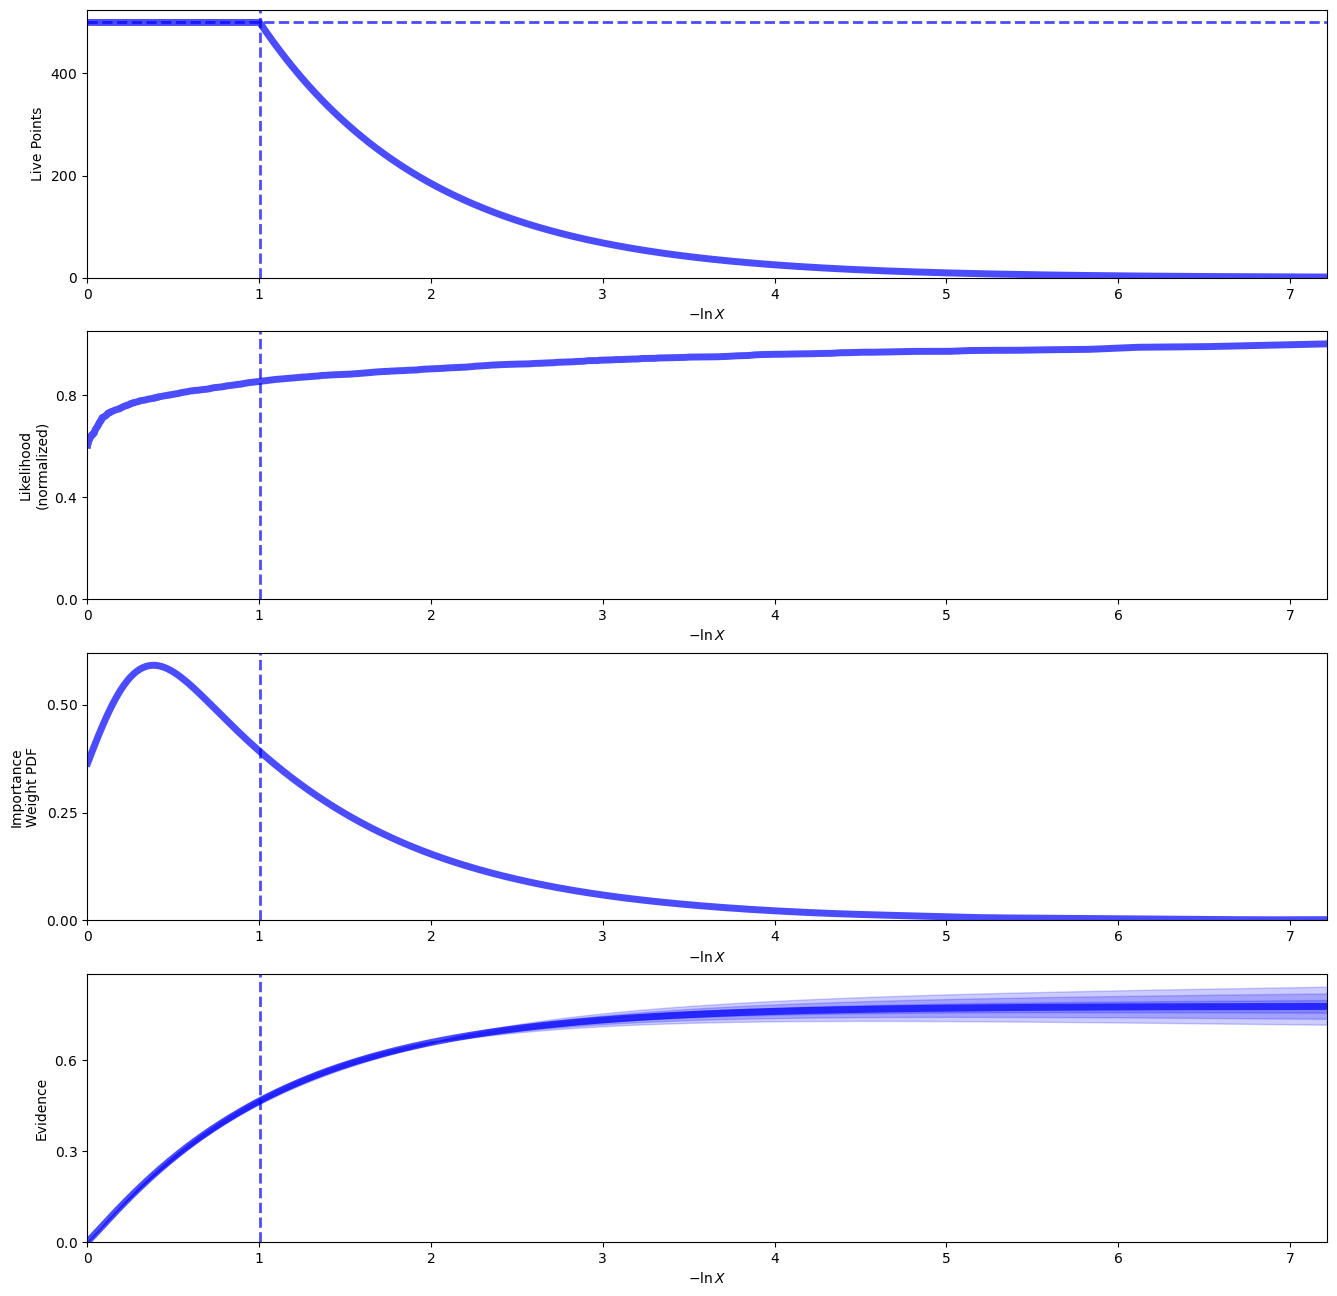

In [ ]:

rfig, raxes = dyplot.runplot(sresults)
rfig.savefig('test.png')

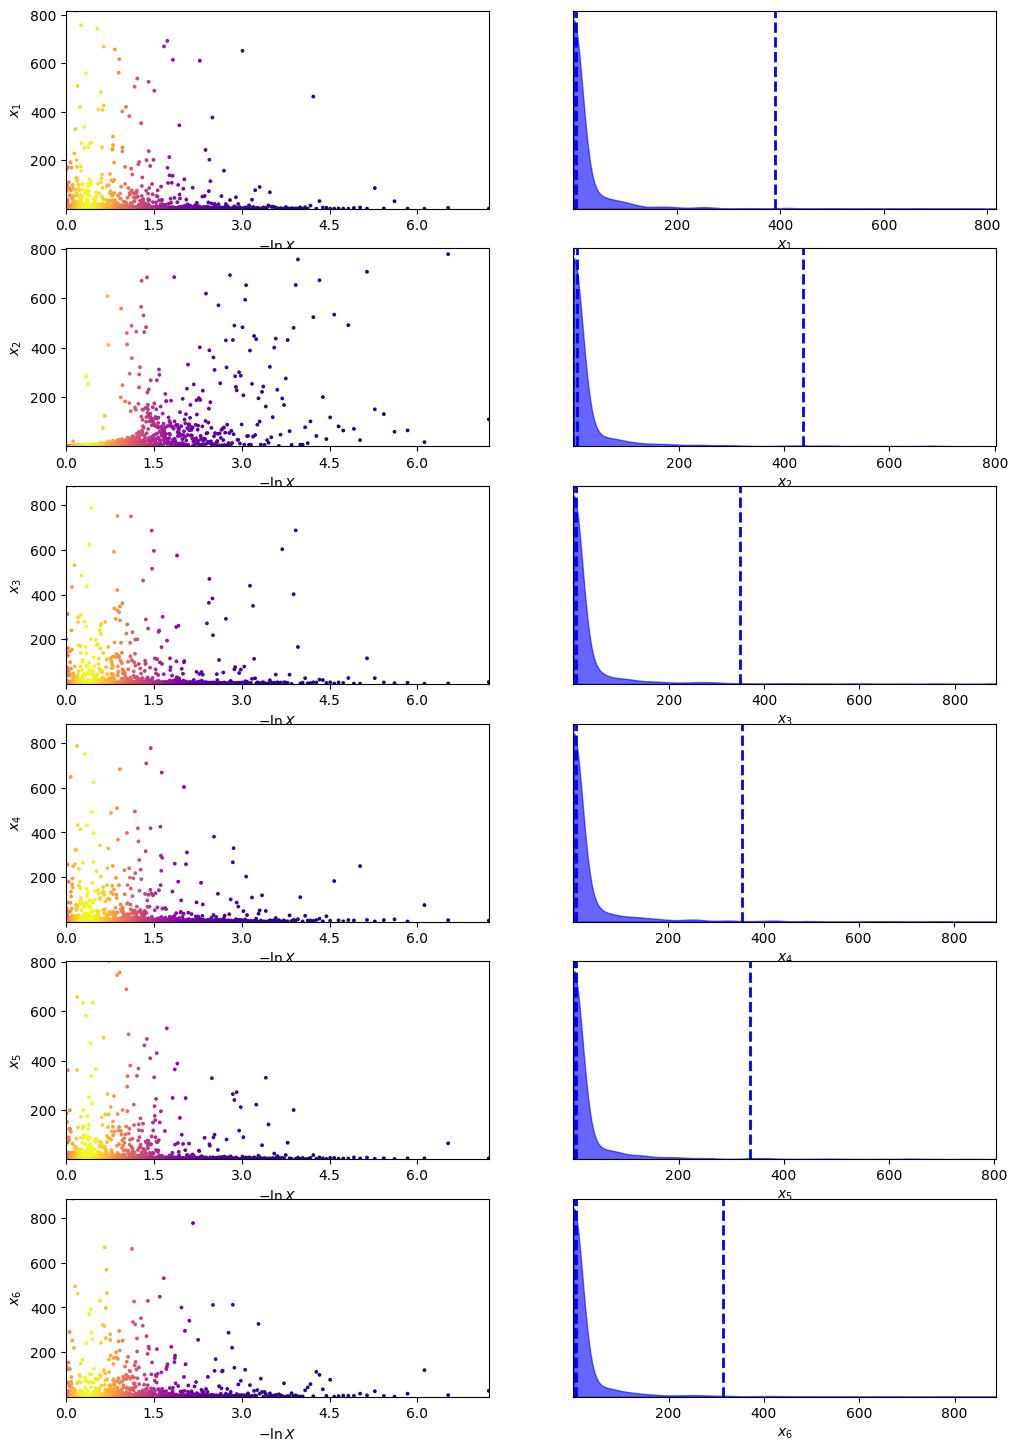

In [ ]:

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(sresults)

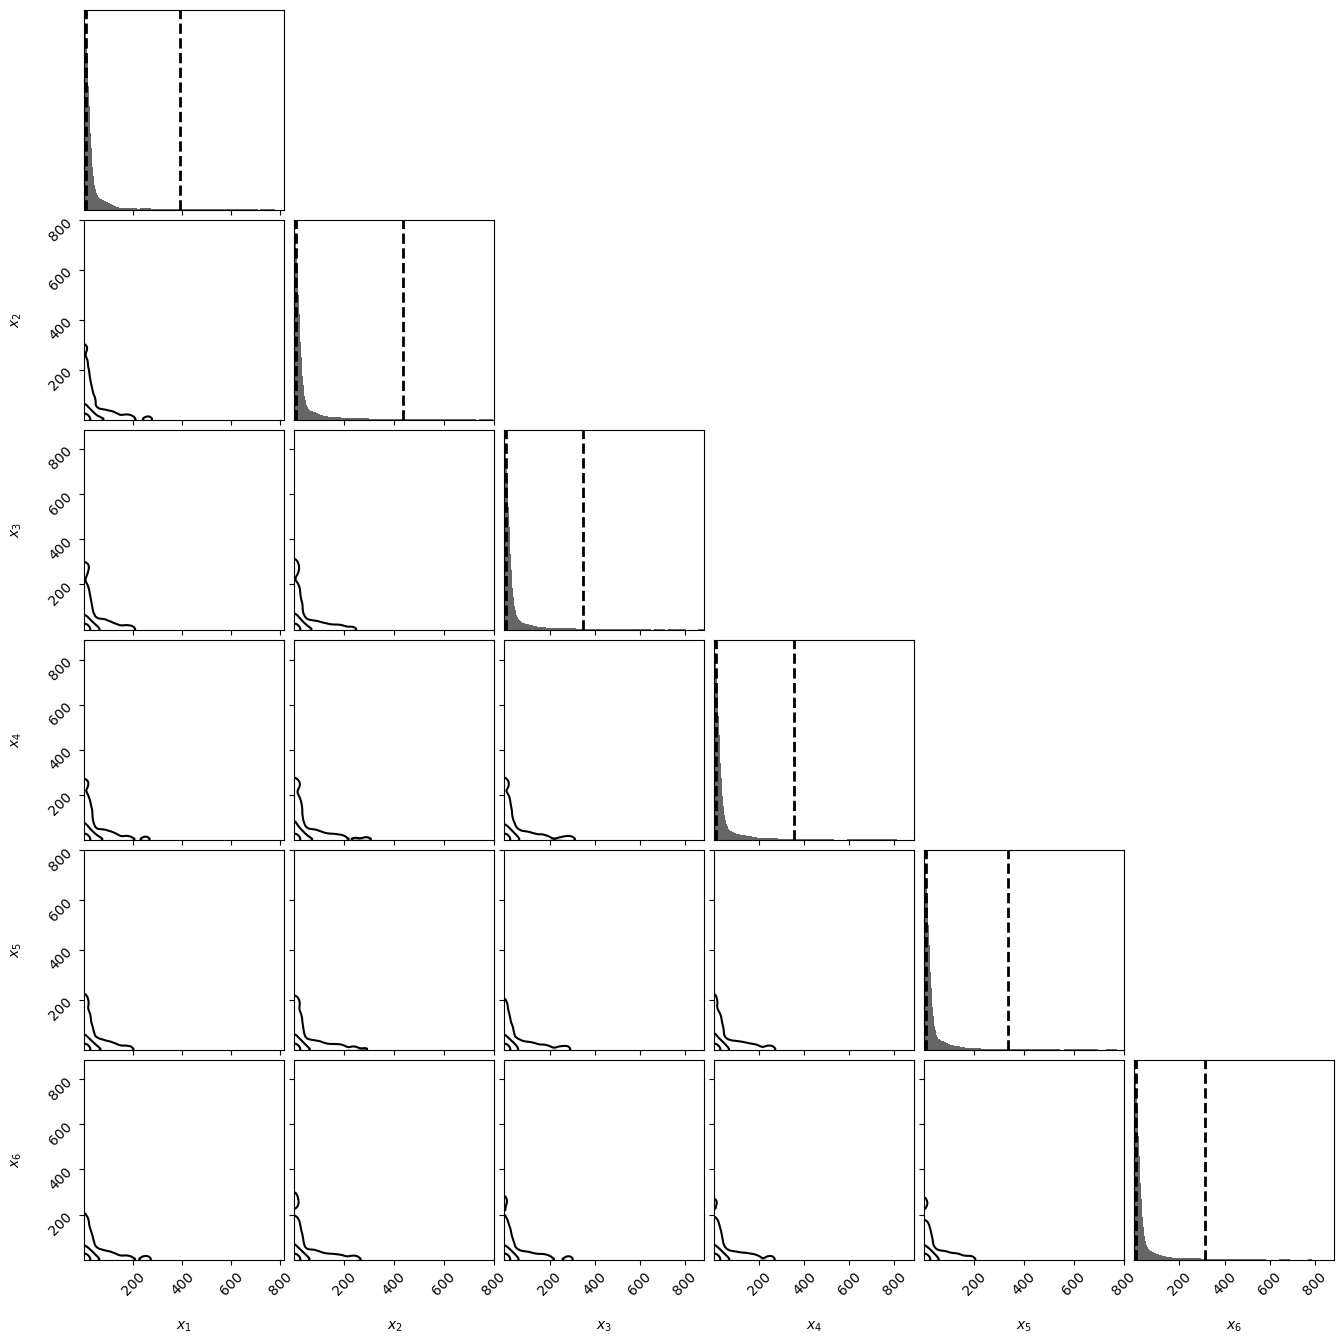

In [ ]:

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(sresults)